Hyperparamters searching

random search all the params, then random search specific params, the evaluator is MLP where representations encoded by the extractor will be put in to cross validate(evaludate the performance then optimize)

network architecture is unknown, optimizer parameters are unknown, embedding size are unknown. Hence, in this notebook, we are trying to find the best architecture and best training params
+ hidden size
+ num of hidden layers
+ embedding size
+ lr 
+ weight decay

In [2]:
import gc
import os
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pickle
from sklearn.utils import resample
from collections import Counter
import math
from sklearn.model_selection import train_test_split
import helper
import dataset
import torch
import torch.nn as nn
from resnet1d.net1d import Net1D

In [3]:
data_files = [name for name in os.listdir('./data')]

dfs = []

for i in range(len(data_files)):
    fname = './data/' + data_files[i]
    df = pd.read_csv(fname)
    # df.columns = [x.strip().lstrip() for x in df.columns]

    dfs.append(df)

df = pd.concat(dfs, axis=0, ignore_index=True)

df.shape

(2830743, 79)

In [4]:
# Remove spaces in the front and the end of the column names for better human reading
df.columns = [x.lstrip().strip().replace('�', '-') for x in df.columns]
df.shape

(2830743, 79)

In [5]:
# replace inf values to nan
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
df.shape

(2827876, 79)

In [6]:
# remove this when experimenting on the whole dataset
df = resample(df, replace=False, n_samples=20000, stratify=df['Label'])

In [7]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

pca__n_components = 20

preprocessor = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy='most_frequent')),
    ("normalize", MinMaxScaler()),
    ("PCA", PCA(n_components=pca__n_components))
])

label_encoder = LabelEncoder()

In [8]:
X = df.drop(['Label'], axis=1)
y = df['Label']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y)

X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)

# doing this since we need all labels in case there's any labels not found in test set
label_encoder.fit(y)

y_train = label_encoder.transform(y_train)
y_val = label_encoder.transform(y_val)

In [9]:
X_smote, _ = helper.smote_sampling(X_train, y_train)
X_gaussion = helper.add_gaussion(X_smote)
X_flip = helper.invert_array(X_train)

X_new = np.dstack([X_smote, X_gaussion, X_flip])
X_new = X_new.transpose((0, 2, 1))

X_new.shape

(16000, 3, 20)

In [10]:
# batch, channel, feature
X_train = np.expand_dims(X_train, axis=2).transpose((0, 2, 1))
X_train.shape

(16000, 1, 20)

In [11]:
org_dataset = dataset.NumpyDataset(X_train, y_train)
pos_dataset = dataset.NumpyDataset(X_new, y_train)

In [13]:
import time
import warnings
import optuna
from torch.utils.data import DataLoader
from pytorch_metric_learning.losses import SelfSupervisedLoss, NTXentLoss
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold
from models import Extractor, Projector, ExtractorMLP
from models import ExtractorMLP
from itertools import cycle
from torch.utils.tensorboard import SummaryWriter


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
warnings.filterwarnings('ignore')
verbose = False

def objective(trial: optuna.Trial):
    start_time = time.perf_counter()

    hidden_size = trial.suggest_int('hidden_size', 16, 64) 
    embedding_size = trial.suggest_int('embedding_size', 16, 64)
    n_hidden = trial.suggest_int('n_hidden', 2, 5)
    kernel_size = trial.suggest_int('kernel_size', 3, 15)
    stride = trial.suggest_int('stride', 1, 3)
    act = trial.suggest_categorical('act', ['relu', 'swish'])

    params = {
        'hidden_size': hidden_size,
        'embedding_size': embedding_size,
        'n_hidden': n_hidden,
        'kernel_size': kernel_size,
        'stride': stride,
    }

    print(params)

    extractor_1d = ExtractorMLP(n_features=pca__n_components, 
                            n_channels=1,
                            embedding_size=embedding_size,
                            hidden_size=hidden_size,
                            n_hidden=n_hidden,
                            kernel_size=kernel_size, 
                            stride=stride,
                            act=act
                            ).to(device)

    extractor_3d = ExtractorMLP(n_features=pca__n_components, 
                            n_channels=X_new.shape[1],
                            embedding_size=embedding_size,
                            hidden_size=hidden_size,
                            n_hidden=n_hidden,
                            kernel_size=kernel_size, 
                            stride=stride,
                            act=act,
                            ).to(device)

    projector = Projector(embedding_size=embedding_size).to(device)

    lr = 1e-3
    weight_decay = 1e-4
    batch_size = 1024
    epochs = 200

    org_dataloader = DataLoader(org_dataset, batch_size=batch_size,)
    pos_dataloader = DataLoader(pos_dataset, batch_size=batch_size)

    optimizer_1d = torch.optim.Adam(extractor_1d.parameters(), lr=lr, weight_decay=weight_decay)
    optimizer_3d = torch.optim.Adam(extractor_3d.parameters(), lr=lr, weight_decay=weight_decay)
    optimizer_projector = torch.optim.Adam(projector.parameters(), lr=lr, weight_decay=weight_decay)

    loss_fn = NTXentLoss()
    loss_fn = SelfSupervisedLoss(loss_fn, symmetric=False).to(device)

    writer = SummaryWriter(log_dir='./runs')

    cnt = 1

    for epoch in range(epochs):
        total_loss = 0
        for item1, item2 in zip(org_dataloader, cycle(pos_dataloader)):
            X_batch, _ = item1
            X_new_batch, _ = item2

            X_batch = X_batch.to(device)
            X_new_batch = X_new_batch.to(device)

            optimizer_1d.zero_grad()
            optimizer_3d.zero_grad()
            optimizer_projector.zero_grad()

            embedding_1d = extractor_1d(X_batch)
            embedding_3d = extractor_3d(X_new_batch)
            projected_1d = projector(embedding_1d)
            projected_3d = projector(embedding_3d)

            loss = loss_fn(projected_1d, projected_3d)
            loss.backward()

            total_loss += loss.item()
        
            optimizer_1d.step()
            optimizer_3d.step()
            optimizer_projector.step()

        cnt += 1

        if verbose: print(f'[{epoch}/{epochs}]: {total_loss}')
        
        writer.add_scalar(f'Loss/train-{(hidden_size, n_hidden, embedding_size, kernel_size, stride)}', total_loss/cnt, cnt)
                        
    extractor_1d.eval()
    X_val_tensor = torch.tensor(np.expand_dims(X_val, axis=2).transpose((0, 2, 1)), dtype=torch.float32, device=device)

    X_val_embedding = extractor_1d(X_val_tensor)
    X_val_embedding = X_val_embedding.cpu().detach().numpy()

    mlp = MLPClassifier(max_iter=750, verbose=0)
    results = cross_validate(mlp, X_val_embedding, y_val, cv=5, scoring='f1_macro')

    end_time = time.perf_counter()
    elapsed_time = end_time - start_time
    print(f'elapsed {elapsed_time//60}:{elapsed_time % 60}')

    return np.average(results['test_score'])
            

In [12]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

[I 2023-11-14 14:39:30,397] A new study created in memory with name: no-name-efa506b8-9217-4b9a-b132-df2e9dd92d45


{'hidden_size': 19, 'embedding_size': 27, 'n_hidden': 2, 'kernel_size': 4, 'stride': 1}


[I 2023-11-14 14:48:16,689] Trial 0 finished with value: 0.49807622462377477 and parameters: {'hidden_size': 19, 'embedding_size': 27, 'n_hidden': 2, 'kernel_size': 4, 'stride': 1, 'act': 'relu'}. Best is trial 0 with value: 0.49807622462377477.


elapsed 8.0:46.28999856700102
{'hidden_size': 58, 'embedding_size': 47, 'n_hidden': 5, 'kernel_size': 8, 'stride': 2}


[I 2023-11-14 14:56:27,699] Trial 1 finished with value: 0.08783164666659811 and parameters: {'hidden_size': 58, 'embedding_size': 47, 'n_hidden': 5, 'kernel_size': 8, 'stride': 2, 'act': 'swish'}. Best is trial 0 with value: 0.49807622462377477.


elapsed 8.0:11.007475680000425
{'hidden_size': 31, 'embedding_size': 17, 'n_hidden': 5, 'kernel_size': 6, 'stride': 2}


[I 2023-11-14 15:04:41,718] Trial 2 finished with value: 0.08783164666659811 and parameters: {'hidden_size': 31, 'embedding_size': 17, 'n_hidden': 5, 'kernel_size': 6, 'stride': 2, 'act': 'swish'}. Best is trial 0 with value: 0.49807622462377477.


elapsed 8.0:14.017650478001087
{'hidden_size': 64, 'embedding_size': 50, 'n_hidden': 2, 'kernel_size': 13, 'stride': 2}


[I 2023-11-14 15:13:23,512] Trial 3 finished with value: 0.5200893762085674 and parameters: {'hidden_size': 64, 'embedding_size': 50, 'n_hidden': 2, 'kernel_size': 13, 'stride': 2, 'act': 'swish'}. Best is trial 3 with value: 0.5200893762085674.


elapsed 8.0:41.79214929099908
{'hidden_size': 34, 'embedding_size': 51, 'n_hidden': 5, 'kernel_size': 15, 'stride': 2}


[I 2023-11-14 15:21:36,505] Trial 4 finished with value: 0.08783164666659811 and parameters: {'hidden_size': 34, 'embedding_size': 51, 'n_hidden': 5, 'kernel_size': 15, 'stride': 2, 'act': 'swish'}. Best is trial 3 with value: 0.5200893762085674.


elapsed 8.0:12.991294909999851
{'hidden_size': 54, 'embedding_size': 18, 'n_hidden': 5, 'kernel_size': 11, 'stride': 3}


[I 2023-11-14 15:30:07,966] Trial 5 finished with value: 0.183586205169287 and parameters: {'hidden_size': 54, 'embedding_size': 18, 'n_hidden': 5, 'kernel_size': 11, 'stride': 3, 'act': 'relu'}. Best is trial 3 with value: 0.5200893762085674.


elapsed 8.0:31.458900047000498
{'hidden_size': 46, 'embedding_size': 29, 'n_hidden': 2, 'kernel_size': 7, 'stride': 2}


[I 2023-11-14 15:38:54,594] Trial 6 finished with value: 0.528464718689946 and parameters: {'hidden_size': 46, 'embedding_size': 29, 'n_hidden': 2, 'kernel_size': 7, 'stride': 2, 'act': 'swish'}. Best is trial 6 with value: 0.528464718689946.


elapsed 8.0:46.626174796998384
{'hidden_size': 16, 'embedding_size': 46, 'n_hidden': 2, 'kernel_size': 12, 'stride': 2}


[I 2023-11-14 15:47:34,824] Trial 7 finished with value: 0.32517044665881223 and parameters: {'hidden_size': 16, 'embedding_size': 46, 'n_hidden': 2, 'kernel_size': 12, 'stride': 2, 'act': 'swish'}. Best is trial 6 with value: 0.528464718689946.


elapsed 8.0:40.228034413001296
{'hidden_size': 51, 'embedding_size': 26, 'n_hidden': 2, 'kernel_size': 10, 'stride': 3}


[I 2023-11-14 15:56:18,360] Trial 8 finished with value: 0.5798202281961586 and parameters: {'hidden_size': 51, 'embedding_size': 26, 'n_hidden': 2, 'kernel_size': 10, 'stride': 3, 'act': 'relu'}. Best is trial 8 with value: 0.5798202281961586.


elapsed 8.0:43.53411262699956
{'hidden_size': 59, 'embedding_size': 58, 'n_hidden': 4, 'kernel_size': 12, 'stride': 2}


[I 2023-11-14 16:04:28,866] Trial 9 finished with value: 0.08783164666659811 and parameters: {'hidden_size': 59, 'embedding_size': 58, 'n_hidden': 4, 'kernel_size': 12, 'stride': 2, 'act': 'swish'}. Best is trial 8 with value: 0.5798202281961586.


elapsed 8.0:10.504187264003122
{'hidden_size': 45, 'embedding_size': 32, 'n_hidden': 3, 'kernel_size': 9, 'stride': 3}


[I 2023-11-14 16:13:14,656] Trial 10 finished with value: 0.4342104249272367 and parameters: {'hidden_size': 45, 'embedding_size': 32, 'n_hidden': 3, 'kernel_size': 9, 'stride': 3, 'act': 'relu'}. Best is trial 8 with value: 0.5798202281961586.


elapsed 8.0:45.78837087899956
{'hidden_size': 47, 'embedding_size': 33, 'n_hidden': 3, 'kernel_size': 7, 'stride': 3}


[I 2023-11-14 16:21:59,326] Trial 11 finished with value: 0.3996741128504332 and parameters: {'hidden_size': 47, 'embedding_size': 33, 'n_hidden': 3, 'kernel_size': 7, 'stride': 3, 'act': 'relu'}. Best is trial 8 with value: 0.5798202281961586.


elapsed 8.0:44.667964407999534
{'hidden_size': 49, 'embedding_size': 27, 'n_hidden': 3, 'kernel_size': 5, 'stride': 1}


[I 2023-11-14 16:30:46,173] Trial 12 finished with value: 0.41234262878895045 and parameters: {'hidden_size': 49, 'embedding_size': 27, 'n_hidden': 3, 'kernel_size': 5, 'stride': 1, 'act': 'relu'}. Best is trial 8 with value: 0.5798202281961586.


elapsed 8.0:46.84529891499915
{'hidden_size': 40, 'embedding_size': 38, 'n_hidden': 2, 'kernel_size': 10, 'stride': 3}


[I 2023-11-14 16:39:31,788] Trial 13 finished with value: 0.501728769544843 and parameters: {'hidden_size': 40, 'embedding_size': 38, 'n_hidden': 2, 'kernel_size': 10, 'stride': 3, 'act': 'relu'}. Best is trial 8 with value: 0.5798202281961586.


elapsed 8.0:45.61302098899978
{'hidden_size': 39, 'embedding_size': 24, 'n_hidden': 4, 'kernel_size': 3, 'stride': 1}


[I 2023-11-14 16:47:54,375] Trial 14 finished with value: 0.16755391562849747 and parameters: {'hidden_size': 39, 'embedding_size': 24, 'n_hidden': 4, 'kernel_size': 3, 'stride': 1, 'act': 'swish'}. Best is trial 8 with value: 0.5798202281961586.


elapsed 8.0:22.584948515999713
{'hidden_size': 52, 'embedding_size': 38, 'n_hidden': 3, 'kernel_size': 8, 'stride': 3}


[I 2023-11-14 16:56:50,405] Trial 15 finished with value: 0.39097073310225344 and parameters: {'hidden_size': 52, 'embedding_size': 38, 'n_hidden': 3, 'kernel_size': 8, 'stride': 3, 'act': 'relu'}. Best is trial 8 with value: 0.5798202281961586.


elapsed 8.0:56.02818679200209
{'hidden_size': 31, 'embedding_size': 24, 'n_hidden': 2, 'kernel_size': 6, 'stride': 3}


[I 2023-11-14 17:05:43,037] Trial 16 finished with value: 0.44264491708866444 and parameters: {'hidden_size': 31, 'embedding_size': 24, 'n_hidden': 2, 'kernel_size': 6, 'stride': 3, 'act': 'swish'}. Best is trial 8 with value: 0.5798202281961586.


elapsed 8.0:52.63005767100185
{'hidden_size': 44, 'embedding_size': 32, 'n_hidden': 2, 'kernel_size': 10, 'stride': 1}


[I 2023-11-14 17:14:35,045] Trial 17 finished with value: 0.569318626718968 and parameters: {'hidden_size': 44, 'embedding_size': 32, 'n_hidden': 2, 'kernel_size': 10, 'stride': 1, 'act': 'relu'}. Best is trial 8 with value: 0.5798202281961586.


elapsed 8.0:52.006910266001796
{'hidden_size': 24, 'embedding_size': 34, 'n_hidden': 4, 'kernel_size': 14, 'stride': 1}


[I 2023-11-14 17:23:30,698] Trial 18 finished with value: 0.3209428212090625 and parameters: {'hidden_size': 24, 'embedding_size': 34, 'n_hidden': 4, 'kernel_size': 14, 'stride': 1, 'act': 'relu'}. Best is trial 8 with value: 0.5798202281961586.


elapsed 8.0:55.649752036999416
{'hidden_size': 42, 'embedding_size': 43, 'n_hidden': 3, 'kernel_size': 10, 'stride': 1}


[I 2023-11-14 17:32:24,956] Trial 19 finished with value: 0.5115163412331303 and parameters: {'hidden_size': 42, 'embedding_size': 43, 'n_hidden': 3, 'kernel_size': 10, 'stride': 1, 'act': 'relu'}. Best is trial 8 with value: 0.5798202281961586.


elapsed 8.0:54.25632870000118


In [14]:
def objective(trial: optuna.Trial):
    start_time = time.perf_counter()

    hidden_size = trial.suggest_int('hidden_size', 16, 64) 
    embedding_size = 26
    n_hidden = trial.suggest_int('n_hidden', 1, 2)
    kernel_size = 10
    stride = 3
    act = 'relu'

    params = {
        'hidden_size': hidden_size,
        'embedding_size': embedding_size,
        'n_hidden': n_hidden,
        'kernel_size': kernel_size,
        'stride': stride,
    }

    print(params)

    extractor_1d = ExtractorMLP(n_features=pca__n_components, 
                            n_channels=1,
                            embedding_size=embedding_size,
                            hidden_size=hidden_size,
                            n_hidden=n_hidden,
                            kernel_size=kernel_size, 
                            stride=stride,
                            act=act
                            ).to(device)

    extractor_3d = ExtractorMLP(n_features=pca__n_components, 
                            n_channels=X_new.shape[1],
                            embedding_size=embedding_size,
                            hidden_size=hidden_size,
                            n_hidden=n_hidden,
                            kernel_size=kernel_size, 
                            stride=stride,
                            act=act,
                            ).to(device)

    projector = Projector(embedding_size=embedding_size).to(device)

    lr = 1e-3
    weight_decay = 1e-4
    batch_size = 1024
    epochs = 200

    org_dataloader = DataLoader(org_dataset, batch_size=batch_size,)
    pos_dataloader = DataLoader(pos_dataset, batch_size=batch_size)

    optimizer_1d = torch.optim.Adam(extractor_1d.parameters(), lr=lr, weight_decay=weight_decay)
    optimizer_3d = torch.optim.Adam(extractor_3d.parameters(), lr=lr, weight_decay=weight_decay)
    optimizer_projector = torch.optim.Adam(projector.parameters(), lr=lr, weight_decay=weight_decay)

    loss_fn = NTXentLoss()
    loss_fn = SelfSupervisedLoss(loss_fn, symmetric=False).to(device)

    writer = SummaryWriter(log_dir='./runs')

    cnt = 1

    for epoch in range(epochs):
        total_loss = 0
        for item1, item2 in zip(org_dataloader, cycle(pos_dataloader)):
            X_batch, _ = item1
            X_new_batch, _ = item2

            X_batch = X_batch.to(device)
            X_new_batch = X_new_batch.to(device)

            optimizer_1d.zero_grad()
            optimizer_3d.zero_grad()
            optimizer_projector.zero_grad()

            embedding_1d = extractor_1d(X_batch)
            embedding_3d = extractor_3d(X_new_batch)
            projected_1d = projector(embedding_1d)
            projected_3d = projector(embedding_3d)

            loss = loss_fn(projected_1d, projected_3d)
            loss.backward()

            total_loss += loss.item()
        
            optimizer_1d.step()
            optimizer_3d.step()
            optimizer_projector.step()

        cnt += 1

        if verbose: print(f'[{epoch}/{epochs}]: {total_loss}')
        
        writer.add_scalar(f'Loss/train-hidden({n_hidden}, {hidden_size})-', total_loss, cnt)
                        
    extractor_1d.eval()
    X_val_tensor = torch.tensor(np.expand_dims(X_val, axis=2).transpose((0, 2, 1)), dtype=torch.float32, device=device)

    X_val_embedding = extractor_1d(X_val_tensor)
    X_val_embedding = X_val_embedding.cpu().detach().numpy()

    mlp = MLPClassifier(max_iter=1500, verbose=0)
    results = cross_validate(mlp, X_val_embedding, y_val, cv=5, scoring='f1_macro')

    end_time = time.perf_counter()
    elapsed_time = end_time - start_time
    print(f'elapsed {elapsed_time//60}:{elapsed_time % 60}')

    return np.average(results['test_score'])
            

In [16]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

[I 2023-11-15 19:20:16,024] A new study created in memory with name: no-name-73c2309b-9882-4be3-b0f9-028e2ac73e5e


{'hidden_size': 25, 'embedding_size': 26, 'n_hidden': 2, 'kernel_size': 10, 'stride': 3}


[I 2023-11-15 19:29:02,919] Trial 0 finished with value: 0.4397482452567495 and parameters: {'hidden_size': 25, 'n_hidden': 2}. Best is trial 0 with value: 0.4397482452567495.


elapsed 8.0:46.8920585679989
{'hidden_size': 27, 'embedding_size': 26, 'n_hidden': 2, 'kernel_size': 10, 'stride': 3}


[I 2023-11-15 19:37:51,624] Trial 1 finished with value: 0.39325401446381264 and parameters: {'hidden_size': 27, 'n_hidden': 2}. Best is trial 0 with value: 0.4397482452567495.


elapsed 8.0:48.70214500400107
{'hidden_size': 29, 'embedding_size': 26, 'n_hidden': 2, 'kernel_size': 10, 'stride': 3}


[I 2023-11-15 19:46:28,618] Trial 2 finished with value: 0.46031113215795855 and parameters: {'hidden_size': 29, 'n_hidden': 2}. Best is trial 2 with value: 0.46031113215795855.


elapsed 8.0:36.99201499600167
{'hidden_size': 51, 'embedding_size': 26, 'n_hidden': 1, 'kernel_size': 10, 'stride': 3}


[I 2023-11-15 19:54:53,548] Trial 3 finished with value: 0.48947820852840573 and parameters: {'hidden_size': 51, 'n_hidden': 1}. Best is trial 3 with value: 0.48947820852840573.


elapsed 8.0:24.928921292001178
{'hidden_size': 46, 'embedding_size': 26, 'n_hidden': 1, 'kernel_size': 10, 'stride': 3}


[I 2023-11-15 20:03:27,357] Trial 4 finished with value: 0.4722121612334503 and parameters: {'hidden_size': 46, 'n_hidden': 1}. Best is trial 3 with value: 0.48947820852840573.


elapsed 8.0:33.807728877000045
{'hidden_size': 36, 'embedding_size': 26, 'n_hidden': 2, 'kernel_size': 10, 'stride': 3}


[I 2023-11-15 20:12:17,432] Trial 5 finished with value: 0.43996085303298765 and parameters: {'hidden_size': 36, 'n_hidden': 2}. Best is trial 3 with value: 0.48947820852840573.


elapsed 8.0:50.07293932800167
{'hidden_size': 42, 'embedding_size': 26, 'n_hidden': 1, 'kernel_size': 10, 'stride': 3}


[I 2023-11-15 20:21:06,014] Trial 6 finished with value: 0.5359613383775612 and parameters: {'hidden_size': 42, 'n_hidden': 1}. Best is trial 6 with value: 0.5359613383775612.


elapsed 8.0:48.58050287500009
{'hidden_size': 60, 'embedding_size': 26, 'n_hidden': 1, 'kernel_size': 10, 'stride': 3}


[I 2023-11-15 20:29:54,221] Trial 7 finished with value: 0.6162353864723314 and parameters: {'hidden_size': 60, 'n_hidden': 1}. Best is trial 7 with value: 0.6162353864723314.


elapsed 8.0:48.204924360001314
{'hidden_size': 18, 'embedding_size': 26, 'n_hidden': 1, 'kernel_size': 10, 'stride': 3}


[I 2023-11-15 20:38:46,203] Trial 8 finished with value: 0.4873669422430008 and parameters: {'hidden_size': 18, 'n_hidden': 1}. Best is trial 7 with value: 0.6162353864723314.


elapsed 8.0:52.53317626900025
{'hidden_size': 51, 'embedding_size': 26, 'n_hidden': 1, 'kernel_size': 10, 'stride': 3}


[I 2023-11-15 20:47:34,465] Trial 9 finished with value: 0.47984361896434924 and parameters: {'hidden_size': 51, 'n_hidden': 1}. Best is trial 7 with value: 0.6162353864723314.


elapsed 8.0:48.26042921399858


In [12]:
def objective(trial: optuna.Trial):
    start_time = time.perf_counter()

    hidden_size = trial.suggest_int('hidden_size', 48, 256) 
    embedding_size = trial.suggest_int('embedding_size', 8, 64)
    n_hidden = trial.suggest_int('n_hidden', 1, 3)
    kernel_size = trial.suggest_int('kernel_size', 1, 20)
    stride = trial.suggest_int('stride', 1, 3)
    act = trial.suggest_categorical('act', ['relu', 'swish'])
    lr = trial.suggest_float('lr', 1e-4, 1e-1)
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-2)

    batch_size = 1024
    epochs = 200

    params = {
        'hidden_size': hidden_size,
        'embedding_size': embedding_size,
        'n_hidden': n_hidden,
        'kernel_size': kernel_size,
        'stride': stride,
        'lr': lr,
        'weight_decay': weight_decay,
        'act': act
    }

    channel = "Loss/train#" +  "-".join([f'{k}({v})' for k, v in params.items()]) 

    print(params)

    extractor_1d = ExtractorMLP(n_features=pca__n_components, 
                            n_channels=1,
                            embedding_size=embedding_size,
                            hidden_size=hidden_size,
                            n_hidden=n_hidden,
                            kernel_size=kernel_size, 
                            stride=stride,
                            act=act
                            ).to(device)

    extractor_3d = ExtractorMLP(n_features=pca__n_components, 
                            n_channels=X_new.shape[1],
                            embedding_size=embedding_size,
                            hidden_size=hidden_size,
                            n_hidden=n_hidden,
                            kernel_size=kernel_size, 
                            stride=stride,
                            act=act,
                            ).to(device)

    projector = Projector(embedding_size=embedding_size).to(device)


    org_dataloader = DataLoader(org_dataset, batch_size=batch_size,)
    pos_dataloader = DataLoader(pos_dataset, batch_size=batch_size)

    optimizer_1d = torch.optim.Adam(extractor_1d.parameters(), lr=lr, weight_decay=weight_decay)
    optimizer_3d = torch.optim.Adam(extractor_3d.parameters(), lr=lr, weight_decay=weight_decay)
    optimizer_projector = torch.optim.Adam(projector.parameters(), lr=lr, weight_decay=weight_decay)

    loss_fn = NTXentLoss()
    loss_fn = SelfSupervisedLoss(loss_fn, symmetric=False).to(device)

    writer = SummaryWriter(log_dir='./runs')

    cnt = 1

    for epoch in range(epochs):
        total_loss = 0
        for item1, item2 in zip(org_dataloader, cycle(pos_dataloader)):
            X_batch, _ = item1
            X_new_batch, _ = item2

            X_batch = X_batch.to(device)
            X_new_batch = X_new_batch.to(device)

            optimizer_1d.zero_grad()
            optimizer_3d.zero_grad()
            optimizer_projector.zero_grad()

            embedding_1d = extractor_1d(X_batch)
            embedding_3d = extractor_3d(X_new_batch)
            projected_1d = projector(embedding_1d)
            projected_3d = projector(embedding_3d)

            loss = loss_fn(projected_1d, projected_3d)
            loss.backward()

            total_loss += loss.item()
        
            optimizer_1d.step()
            optimizer_3d.step()
            optimizer_projector.step()

        cnt += 1

        if verbose: print(f'[{epoch}/{epochs}]: {total_loss}')
        
        writer.add_scalar(channel, total_loss, cnt)
                        
    extractor_1d.eval()
    X_val_tensor = torch.tensor(np.expand_dims(X_val, axis=2).transpose((0, 2, 1)), dtype=torch.float32, device=device)

    X_val_embedding = extractor_1d(X_val_tensor)
    X_val_embedding = X_val_embedding.cpu().detach().numpy()

    mlp = MLPClassifier(max_iter=750, verbose=0)
    results = cross_validate(mlp, X_val_embedding, y_val, cv=5, scoring='f1_macro')

    end_time = time.perf_counter()
    elapsed_time = end_time - start_time
    print(f'elapsed {elapsed_time//60}:{elapsed_time % 60}')

    return np.average(results['test_score'])
            

In [13]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=60)

[I 2023-11-15 22:47:15,187] A new study created in memory with name: no-name-af971bae-4cfa-456b-bc2f-f179f1567e77


{'hidden_size': 152, 'embedding_size': 12, 'n_hidden': 2, 'kernel_size': 16, 'stride': 3, 'lr': 0.02457844082554596, 'weight_decay': 0.007770008313149937, 'act': 'relu'}


[I 2023-11-15 22:55:01,179] Trial 0 finished with value: 0.08747016824686729 and parameters: {'hidden_size': 152, 'embedding_size': 12, 'n_hidden': 2, 'kernel_size': 16, 'stride': 3, 'act': 'relu', 'lr': 0.02457844082554596, 'weight_decay': 0.007770008313149937}. Best is trial 0 with value: 0.08747016824686729.


elapsed 7.0:45.99011280400032
{'hidden_size': 61, 'embedding_size': 43, 'n_hidden': 2, 'kernel_size': 19, 'stride': 1, 'lr': 0.03672194215936403, 'weight_decay': 0.0020288378430055806, 'act': 'relu'}


[I 2023-11-15 23:03:01,061] Trial 1 finished with value: 0.7423794253056875 and parameters: {'hidden_size': 61, 'embedding_size': 43, 'n_hidden': 2, 'kernel_size': 19, 'stride': 1, 'act': 'relu', 'lr': 0.03672194215936403, 'weight_decay': 0.0020288378430055806}. Best is trial 1 with value: 0.7423794253056875.


elapsed 7.0:59.88053908399979
{'hidden_size': 147, 'embedding_size': 56, 'n_hidden': 3, 'kernel_size': 20, 'stride': 3, 'lr': 0.02123724503043127, 'weight_decay': 0.00014097471975449782, 'act': 'swish'}


[I 2023-11-15 23:10:45,049] Trial 2 finished with value: 0.6383777650697814 and parameters: {'hidden_size': 147, 'embedding_size': 56, 'n_hidden': 3, 'kernel_size': 20, 'stride': 3, 'act': 'swish', 'lr': 0.02123724503043127, 'weight_decay': 0.00014097471975449782}. Best is trial 1 with value: 0.7423794253056875.


elapsed 7.0:43.98546198000031
{'hidden_size': 172, 'embedding_size': 13, 'n_hidden': 1, 'kernel_size': 7, 'stride': 2, 'lr': 0.018091654705218552, 'weight_decay': 0.007987418495027697, 'act': 'swish'}


[I 2023-11-15 23:18:38,712] Trial 3 finished with value: 0.6476453694926138 and parameters: {'hidden_size': 172, 'embedding_size': 13, 'n_hidden': 1, 'kernel_size': 7, 'stride': 2, 'act': 'swish', 'lr': 0.018091654705218552, 'weight_decay': 0.007987418495027697}. Best is trial 1 with value: 0.7423794253056875.


elapsed 7.0:53.66103936699983
{'hidden_size': 56, 'embedding_size': 45, 'n_hidden': 1, 'kernel_size': 20, 'stride': 1, 'lr': 0.036219990639691606, 'weight_decay': 0.006671814442944359, 'act': 'relu'}


[I 2023-11-15 23:26:46,829] Trial 4 finished with value: 0.7216168812525825 and parameters: {'hidden_size': 56, 'embedding_size': 45, 'n_hidden': 1, 'kernel_size': 20, 'stride': 1, 'act': 'relu', 'lr': 0.036219990639691606, 'weight_decay': 0.006671814442944359}. Best is trial 1 with value: 0.7423794253056875.


elapsed 8.0:8.116015613999934
{'hidden_size': 80, 'embedding_size': 36, 'n_hidden': 3, 'kernel_size': 5, 'stride': 1, 'lr': 0.08865523427943138, 'weight_decay': 0.00028557003673377484, 'act': 'swish'}


[I 2023-11-15 23:34:30,918] Trial 5 finished with value: 0.5165946434659954 and parameters: {'hidden_size': 80, 'embedding_size': 36, 'n_hidden': 3, 'kernel_size': 5, 'stride': 1, 'act': 'swish', 'lr': 0.08865523427943138, 'weight_decay': 0.00028557003673377484}. Best is trial 1 with value: 0.7423794253056875.


elapsed 7.0:44.08701385199993
{'hidden_size': 153, 'embedding_size': 17, 'n_hidden': 3, 'kernel_size': 1, 'stride': 3, 'lr': 0.06193529388094005, 'weight_decay': 0.007079934424346103, 'act': 'swish'}


[I 2023-11-15 23:42:19,143] Trial 6 finished with value: 0.08747016824686729 and parameters: {'hidden_size': 153, 'embedding_size': 17, 'n_hidden': 3, 'kernel_size': 1, 'stride': 3, 'act': 'swish', 'lr': 0.06193529388094005, 'weight_decay': 0.007079934424346103}. Best is trial 1 with value: 0.7423794253056875.


elapsed 7.0:48.223181534000105
{'hidden_size': 53, 'embedding_size': 40, 'n_hidden': 1, 'kernel_size': 4, 'stride': 1, 'lr': 0.07453606376475949, 'weight_decay': 0.003265826139759075, 'act': 'relu'}


[I 2023-11-15 23:50:07,777] Trial 7 finished with value: 0.687546869874619 and parameters: {'hidden_size': 53, 'embedding_size': 40, 'n_hidden': 1, 'kernel_size': 4, 'stride': 1, 'act': 'relu', 'lr': 0.07453606376475949, 'weight_decay': 0.003265826139759075}. Best is trial 1 with value: 0.7423794253056875.


elapsed 7.0:48.63143511300041
{'hidden_size': 156, 'embedding_size': 54, 'n_hidden': 3, 'kernel_size': 16, 'stride': 2, 'lr': 0.05029194836707987, 'weight_decay': 0.0048434100210824164, 'act': 'swish'}


[I 2023-11-15 23:57:52,226] Trial 8 finished with value: 0.08747016824686729 and parameters: {'hidden_size': 156, 'embedding_size': 54, 'n_hidden': 3, 'kernel_size': 16, 'stride': 2, 'act': 'swish', 'lr': 0.05029194836707987, 'weight_decay': 0.0048434100210824164}. Best is trial 1 with value: 0.7423794253056875.


elapsed 7.0:44.44739776099959
{'hidden_size': 254, 'embedding_size': 49, 'n_hidden': 2, 'kernel_size': 18, 'stride': 2, 'lr': 0.09428438359747023, 'weight_decay': 0.005565473918290975, 'act': 'swish'}


[I 2023-11-16 00:05:36,592] Trial 9 finished with value: 0.08747016824686729 and parameters: {'hidden_size': 254, 'embedding_size': 49, 'n_hidden': 2, 'kernel_size': 18, 'stride': 2, 'act': 'swish', 'lr': 0.09428438359747023, 'weight_decay': 0.005565473918290975}. Best is trial 1 with value: 0.7423794253056875.


elapsed 7.0:44.36397235300046
{'hidden_size': 103, 'embedding_size': 28, 'n_hidden': 2, 'kernel_size': 12, 'stride': 1, 'lr': 0.004195100760250925, 'weight_decay': 0.0026018559172913, 'act': 'relu'}


[I 2023-11-16 00:13:48,779] Trial 10 finished with value: 0.6783897644105262 and parameters: {'hidden_size': 103, 'embedding_size': 28, 'n_hidden': 2, 'kernel_size': 12, 'stride': 1, 'act': 'relu', 'lr': 0.004195100760250925, 'weight_decay': 0.0026018559172913}. Best is trial 1 with value: 0.7423794253056875.


elapsed 8.0:12.185841911999887
{'hidden_size': 55, 'embedding_size': 63, 'n_hidden': 1, 'kernel_size': 12, 'stride': 1, 'lr': 0.03997915396314724, 'weight_decay': 0.009958145209995346, 'act': 'relu'}


[I 2023-11-16 00:21:40,744] Trial 11 finished with value: 0.6152676073441268 and parameters: {'hidden_size': 55, 'embedding_size': 63, 'n_hidden': 1, 'kernel_size': 12, 'stride': 1, 'act': 'relu', 'lr': 0.03997915396314724, 'weight_decay': 0.009958145209995346}. Best is trial 1 with value: 0.7423794253056875.


elapsed 7.0:51.963144618000115
{'hidden_size': 106, 'embedding_size': 42, 'n_hidden': 1, 'kernel_size': 20, 'stride': 1, 'lr': 0.03876017039552588, 'weight_decay': 0.0024389462027462473, 'act': 'relu'}


[I 2023-11-16 00:29:35,972] Trial 12 finished with value: 0.7321548806800224 and parameters: {'hidden_size': 106, 'embedding_size': 42, 'n_hidden': 1, 'kernel_size': 20, 'stride': 1, 'act': 'relu', 'lr': 0.03876017039552588, 'weight_decay': 0.0024389462027462473}. Best is trial 1 with value: 0.7423794253056875.


elapsed 7.0:55.22537151399956
{'hidden_size': 109, 'embedding_size': 30, 'n_hidden': 2, 'kernel_size': 15, 'stride': 1, 'lr': 0.052516167355445995, 'weight_decay': 0.001862350958444307, 'act': 'relu'}


[I 2023-11-16 00:37:26,282] Trial 13 finished with value: 0.673731948988463 and parameters: {'hidden_size': 109, 'embedding_size': 30, 'n_hidden': 2, 'kernel_size': 15, 'stride': 1, 'act': 'relu', 'lr': 0.052516167355445995, 'weight_decay': 0.001862350958444307}. Best is trial 1 with value: 0.7423794253056875.


elapsed 7.0:50.30897134299994
{'hidden_size': 109, 'embedding_size': 25, 'n_hidden': 1, 'kernel_size': 10, 'stride': 2, 'lr': 0.037333408343992486, 'weight_decay': 0.0038430884031813678, 'act': 'relu'}


[I 2023-11-16 00:45:19,843] Trial 14 finished with value: 0.6962924219159592 and parameters: {'hidden_size': 109, 'embedding_size': 25, 'n_hidden': 1, 'kernel_size': 10, 'stride': 2, 'act': 'relu', 'lr': 0.037333408343992486, 'weight_decay': 0.0038430884031813678}. Best is trial 1 with value: 0.7423794253056875.


elapsed 7.0:53.55824495500019
{'hidden_size': 86, 'embedding_size': 38, 'n_hidden': 2, 'kernel_size': 18, 'stride': 1, 'lr': 0.06382237668992231, 'weight_decay': 0.0015822810266694826, 'act': 'relu'}


[I 2023-11-16 00:53:03,422] Trial 15 finished with value: 0.08747016824686729 and parameters: {'hidden_size': 86, 'embedding_size': 38, 'n_hidden': 2, 'kernel_size': 18, 'stride': 1, 'act': 'relu', 'lr': 0.06382237668992231, 'weight_decay': 0.0015822810266694826}. Best is trial 1 with value: 0.7423794253056875.


elapsed 7.0:43.577648290998695
{'hidden_size': 200, 'embedding_size': 46, 'n_hidden': 1, 'kernel_size': 14, 'stride': 2, 'lr': 0.03330648119361483, 'weight_decay': 0.003963199211151629, 'act': 'relu'}


[I 2023-11-16 01:01:01,428] Trial 16 finished with value: 0.6940382697887582 and parameters: {'hidden_size': 200, 'embedding_size': 46, 'n_hidden': 1, 'kernel_size': 14, 'stride': 2, 'act': 'relu', 'lr': 0.03330648119361483, 'weight_decay': 0.003963199211151629}. Best is trial 1 with value: 0.7423794253056875.


elapsed 7.0:58.00333472499915
{'hidden_size': 124, 'embedding_size': 34, 'n_hidden': 2, 'kernel_size': 18, 'stride': 1, 'lr': 0.047195349434233966, 'weight_decay': 0.0014293769193662006, 'act': 'relu'}


[I 2023-11-16 01:08:51,292] Trial 17 finished with value: 0.7049503606028453 and parameters: {'hidden_size': 124, 'embedding_size': 34, 'n_hidden': 2, 'kernel_size': 18, 'stride': 1, 'act': 'relu', 'lr': 0.047195349434233966, 'weight_decay': 0.0014293769193662006}. Best is trial 1 with value: 0.7423794253056875.


elapsed 7.0:49.86146825600008
{'hidden_size': 79, 'embedding_size': 53, 'n_hidden': 1, 'kernel_size': 9, 'stride': 2, 'lr': 0.00041103707147372576, 'weight_decay': 0.002920536676442056, 'act': 'relu'}


[I 2023-11-16 01:17:06,026] Trial 18 finished with value: 0.5484021953729886 and parameters: {'hidden_size': 79, 'embedding_size': 53, 'n_hidden': 1, 'kernel_size': 9, 'stride': 2, 'act': 'relu', 'lr': 0.00041103707147372576, 'weight_decay': 0.002920536676442056}. Best is trial 1 with value: 0.7423794253056875.


elapsed 8.0:14.732686203000412
{'hidden_size': 199, 'embedding_size': 62, 'n_hidden': 2, 'kernel_size': 20, 'stride': 1, 'lr': 0.028793192057794903, 'weight_decay': 0.002111165451399704, 'act': 'relu'}


[I 2023-11-16 01:25:01,610] Trial 19 finished with value: 0.6179820768033485 and parameters: {'hidden_size': 199, 'embedding_size': 62, 'n_hidden': 2, 'kernel_size': 20, 'stride': 1, 'act': 'relu', 'lr': 0.028793192057794903, 'weight_decay': 0.002111165451399704}. Best is trial 1 with value: 0.7423794253056875.


elapsed 7.0:55.581624765000015
{'hidden_size': 132, 'embedding_size': 42, 'n_hidden': 3, 'kernel_size': 13, 'stride': 2, 'lr': 0.011724806970176693, 'weight_decay': 0.0012651126791119601, 'act': 'relu'}


[I 2023-11-16 01:33:04,670] Trial 20 finished with value: 0.5362459545465574 and parameters: {'hidden_size': 132, 'embedding_size': 42, 'n_hidden': 3, 'kernel_size': 13, 'stride': 2, 'act': 'relu', 'lr': 0.011724806970176693, 'weight_decay': 0.0012651126791119601}. Best is trial 1 with value: 0.7423794253056875.


elapsed 8.0:3.0586485599997104
{'hidden_size': 49, 'embedding_size': 45, 'n_hidden': 1, 'kernel_size': 20, 'stride': 1, 'lr': 0.039319488986650074, 'weight_decay': 0.0051379829266760615, 'act': 'relu'}


[I 2023-11-16 01:41:06,452] Trial 21 finished with value: 0.6722243062220408 and parameters: {'hidden_size': 49, 'embedding_size': 45, 'n_hidden': 1, 'kernel_size': 20, 'stride': 1, 'act': 'relu', 'lr': 0.039319488986650074, 'weight_decay': 0.0051379829266760615}. Best is trial 1 with value: 0.7423794253056875.


elapsed 8.0:1.780231669999921
{'hidden_size': 68, 'embedding_size': 49, 'n_hidden': 1, 'kernel_size': 18, 'stride': 1, 'lr': 0.027799906875074817, 'weight_decay': 0.0036478931653911835, 'act': 'relu'}


[I 2023-11-16 01:49:13,741] Trial 22 finished with value: 0.7562845197610993 and parameters: {'hidden_size': 68, 'embedding_size': 49, 'n_hidden': 1, 'kernel_size': 18, 'stride': 1, 'act': 'relu', 'lr': 0.027799906875074817, 'weight_decay': 0.0036478931653911835}. Best is trial 22 with value: 0.7562845197610993.


elapsed 8.0:7.286426935999771
{'hidden_size': 78, 'embedding_size': 50, 'n_hidden': 1, 'kernel_size': 17, 'stride': 1, 'lr': 0.02894959384444136, 'weight_decay': 0.003456555917638159, 'act': 'relu'}


[I 2023-11-16 01:57:15,772] Trial 23 finished with value: 0.699906258402093 and parameters: {'hidden_size': 78, 'embedding_size': 50, 'n_hidden': 1, 'kernel_size': 17, 'stride': 1, 'act': 'relu', 'lr': 0.02894959384444136, 'weight_decay': 0.003456555917638159}. Best is trial 22 with value: 0.7562845197610993.


elapsed 8.0:2.0297420659990166
{'hidden_size': 68, 'embedding_size': 58, 'n_hidden': 1, 'kernel_size': 18, 'stride': 1, 'lr': 0.01642591340853229, 'weight_decay': 0.002603307524765625, 'act': 'relu'}


[I 2023-11-16 02:05:18,576] Trial 24 finished with value: 0.7199043958852975 and parameters: {'hidden_size': 68, 'embedding_size': 58, 'n_hidden': 1, 'kernel_size': 18, 'stride': 1, 'act': 'relu', 'lr': 0.01642591340853229, 'weight_decay': 0.002603307524765625}. Best is trial 22 with value: 0.7562845197610993.


elapsed 8.0:2.801982038999995
{'hidden_size': 98, 'embedding_size': 33, 'n_hidden': 1, 'kernel_size': 15, 'stride': 1, 'lr': 0.02767970184891713, 'weight_decay': 0.003952530715142223, 'act': 'relu'}


[I 2023-11-16 02:13:18,216] Trial 25 finished with value: 0.727981732167619 and parameters: {'hidden_size': 98, 'embedding_size': 33, 'n_hidden': 1, 'kernel_size': 15, 'stride': 1, 'act': 'relu', 'lr': 0.02767970184891713, 'weight_decay': 0.003952530715142223}. Best is trial 22 with value: 0.7562845197610993.


elapsed 7.0:59.63809227999991
{'hidden_size': 93, 'embedding_size': 21, 'n_hidden': 2, 'kernel_size': 19, 'stride': 1, 'lr': 0.04473568498804614, 'weight_decay': 0.002439087020549618, 'act': 'relu'}


[I 2023-11-16 02:21:25,720] Trial 26 finished with value: 0.6543306426796566 and parameters: {'hidden_size': 93, 'embedding_size': 21, 'n_hidden': 2, 'kernel_size': 19, 'stride': 1, 'act': 'relu', 'lr': 0.04473568498804614, 'weight_decay': 0.002439087020549618}. Best is trial 22 with value: 0.7562845197610993.


elapsed 8.0:7.502241228999992
{'hidden_size': 122, 'embedding_size': 42, 'n_hidden': 1, 'kernel_size': 16, 'stride': 2, 'lr': 0.010098042257117926, 'weight_decay': 0.0009019801258292012, 'act': 'relu'}


[I 2023-11-16 02:29:26,559] Trial 27 finished with value: 0.7153414641984114 and parameters: {'hidden_size': 122, 'embedding_size': 42, 'n_hidden': 1, 'kernel_size': 16, 'stride': 2, 'act': 'relu', 'lr': 0.010098042257117926, 'weight_decay': 0.0009019801258292012}. Best is trial 22 with value: 0.7562845197610993.


elapsed 8.0:0.8369605650004814
{'hidden_size': 71, 'embedding_size': 50, 'n_hidden': 2, 'kernel_size': 17, 'stride': 1, 'lr': 0.022937373077442993, 'weight_decay': 0.0018834832495298341, 'act': 'relu'}


[I 2023-11-16 02:37:27,805] Trial 28 finished with value: 0.663718975764765 and parameters: {'hidden_size': 71, 'embedding_size': 50, 'n_hidden': 2, 'kernel_size': 17, 'stride': 1, 'act': 'relu', 'lr': 0.022937373077442993, 'weight_decay': 0.0018834832495298341}. Best is trial 22 with value: 0.7562845197610993.


elapsed 8.0:1.2442728290006926
{'hidden_size': 65, 'embedding_size': 39, 'n_hidden': 1, 'kernel_size': 16, 'stride': 3, 'lr': 0.030735362753984943, 'weight_decay': 0.0008242852023075669, 'act': 'relu'}


[I 2023-11-16 02:45:19,174] Trial 29 finished with value: 0.7609625574388434 and parameters: {'hidden_size': 65, 'embedding_size': 39, 'n_hidden': 1, 'kernel_size': 16, 'stride': 3, 'act': 'relu', 'lr': 0.030735362753984943, 'weight_decay': 0.0008242852023075669}. Best is trial 29 with value: 0.7609625574388434.


elapsed 7.0:51.36812943699988
{'hidden_size': 64, 'embedding_size': 32, 'n_hidden': 2, 'kernel_size': 15, 'stride': 3, 'lr': 0.0257769705390921, 'weight_decay': 0.0009238127933038311, 'act': 'relu'}


[I 2023-11-16 02:53:12,187] Trial 30 finished with value: 0.6811590848033404 and parameters: {'hidden_size': 64, 'embedding_size': 32, 'n_hidden': 2, 'kernel_size': 15, 'stride': 3, 'act': 'relu', 'lr': 0.0257769705390921, 'weight_decay': 0.0009238127933038311}. Best is trial 29 with value: 0.7609625574388434.


elapsed 7.0:53.010778413998196
{'hidden_size': 90, 'embedding_size': 38, 'n_hidden': 1, 'kernel_size': 19, 'stride': 3, 'lr': 0.030794412981789827, 'weight_decay': 0.0006785248044500428, 'act': 'relu'}


[I 2023-11-16 03:01:03,981] Trial 31 finished with value: 0.7300072633296331 and parameters: {'hidden_size': 90, 'embedding_size': 38, 'n_hidden': 1, 'kernel_size': 19, 'stride': 3, 'act': 'relu', 'lr': 0.030794412981789827, 'weight_decay': 0.0006785248044500428}. Best is trial 29 with value: 0.7609625574388434.


elapsed 7.0:51.791571901998395
{'hidden_size': 64, 'embedding_size': 43, 'n_hidden': 1, 'kernel_size': 17, 'stride': 3, 'lr': 0.022943107516854865, 'weight_decay': 0.00028822991262664904, 'act': 'relu'}


[I 2023-11-16 03:08:52,260] Trial 32 finished with value: 0.70688061645111 and parameters: {'hidden_size': 64, 'embedding_size': 43, 'n_hidden': 1, 'kernel_size': 17, 'stride': 3, 'act': 'relu', 'lr': 0.022943107516854865, 'weight_decay': 0.00028822991262664904}. Best is trial 29 with value: 0.7609625574388434.


elapsed 7.0:48.27772674199878
{'hidden_size': 48, 'embedding_size': 8, 'n_hidden': 1, 'kernel_size': 19, 'stride': 3, 'lr': 0.03562330433309229, 'weight_decay': 0.002011485479515664, 'act': 'relu'}


[I 2023-11-16 03:16:47,967] Trial 33 finished with value: 0.7016805746313256 and parameters: {'hidden_size': 48, 'embedding_size': 8, 'n_hidden': 1, 'kernel_size': 19, 'stride': 3, 'act': 'relu', 'lr': 0.03562330433309229, 'weight_decay': 0.002011485479515664}. Best is trial 29 with value: 0.7609625574388434.


elapsed 7.0:55.70461591300045
{'hidden_size': 118, 'embedding_size': 47, 'n_hidden': 1, 'kernel_size': 20, 'stride': 2, 'lr': 0.0432197860630268, 'weight_decay': 0.0013859972383595028, 'act': 'swish'}


[I 2023-11-16 03:24:37,931] Trial 34 finished with value: 0.6860466073798271 and parameters: {'hidden_size': 118, 'embedding_size': 47, 'n_hidden': 1, 'kernel_size': 20, 'stride': 2, 'act': 'swish', 'lr': 0.0432197860630268, 'weight_decay': 0.0013859972383595028}. Best is trial 29 with value: 0.7609625574388434.


elapsed 7.0:49.96272578800199
{'hidden_size': 141, 'embedding_size': 57, 'n_hidden': 1, 'kernel_size': 17, 'stride': 1, 'lr': 0.01765387190482623, 'weight_decay': 0.003070816594118367, 'act': 'relu'}


[I 2023-11-16 03:32:46,606] Trial 35 finished with value: 0.7229254980193156 and parameters: {'hidden_size': 141, 'embedding_size': 57, 'n_hidden': 1, 'kernel_size': 17, 'stride': 1, 'act': 'relu', 'lr': 0.01765387190482623, 'weight_decay': 0.003070816594118367}. Best is trial 29 with value: 0.7609625574388434.


elapsed 8.0:8.673147672001505
{'hidden_size': 72, 'embedding_size': 40, 'n_hidden': 3, 'kernel_size': 14, 'stride': 2, 'lr': 0.03315352796151592, 'weight_decay': 0.0023766270399077478, 'act': 'swish'}


[I 2023-11-16 03:40:31,269] Trial 36 finished with value: 0.08747016824686729 and parameters: {'hidden_size': 72, 'embedding_size': 40, 'n_hidden': 3, 'kernel_size': 14, 'stride': 2, 'act': 'swish', 'lr': 0.03315352796151592, 'weight_decay': 0.0023766270399077478}. Best is trial 29 with value: 0.7609625574388434.


elapsed 7.0:44.66116234999936
{'hidden_size': 86, 'embedding_size': 52, 'n_hidden': 1, 'kernel_size': 19, 'stride': 3, 'lr': 0.022413462535770326, 'weight_decay': 0.0008075895887072345, 'act': 'relu'}


[I 2023-11-16 03:48:24,544] Trial 37 finished with value: 0.7218897974808425 and parameters: {'hidden_size': 86, 'embedding_size': 52, 'n_hidden': 1, 'kernel_size': 19, 'stride': 3, 'act': 'relu', 'lr': 0.022413462535770326, 'weight_decay': 0.0008075895887072345}. Best is trial 29 with value: 0.7609625574388434.


elapsed 7.0:53.27310961100011
{'hidden_size': 172, 'embedding_size': 35, 'n_hidden': 1, 'kernel_size': 8, 'stride': 1, 'lr': 0.04146477393550785, 'weight_decay': 9.825131301232064e-05, 'act': 'swish'}


[I 2023-11-16 03:56:08,285] Trial 38 finished with value: 0.6826235983773696 and parameters: {'hidden_size': 172, 'embedding_size': 35, 'n_hidden': 1, 'kernel_size': 8, 'stride': 1, 'act': 'swish', 'lr': 0.04146477393550785, 'weight_decay': 9.825131301232064e-05}. Best is trial 29 with value: 0.7609625574388434.


elapsed 7.0:43.73819824399834
{'hidden_size': 63, 'embedding_size': 38, 'n_hidden': 3, 'kernel_size': 16, 'stride': 1, 'lr': 0.03420812903817563, 'weight_decay': 0.003024744411940927, 'act': 'relu'}


[I 2023-11-16 04:03:52,894] Trial 39 finished with value: 0.08747016824686729 and parameters: {'hidden_size': 63, 'embedding_size': 38, 'n_hidden': 3, 'kernel_size': 16, 'stride': 1, 'act': 'relu', 'lr': 0.03420812903817563, 'weight_decay': 0.003024744411940927}. Best is trial 29 with value: 0.7609625574388434.


elapsed 7.0:44.60713625700009
{'hidden_size': 98, 'embedding_size': 48, 'n_hidden': 2, 'kernel_size': 4, 'stride': 2, 'lr': 0.05103275057211594, 'weight_decay': 0.0017922395539662133, 'act': 'swish'}


[I 2023-11-16 04:11:49,012] Trial 40 finished with value: 0.6080682969911917 and parameters: {'hidden_size': 98, 'embedding_size': 48, 'n_hidden': 2, 'kernel_size': 4, 'stride': 2, 'act': 'swish', 'lr': 0.05103275057211594, 'weight_decay': 0.0017922395539662133}. Best is trial 29 with value: 0.7609625574388434.


elapsed 7.0:56.116725733998464
{'hidden_size': 84, 'embedding_size': 39, 'n_hidden': 1, 'kernel_size': 19, 'stride': 3, 'lr': 0.03239138849535719, 'weight_decay': 0.0005987242938558479, 'act': 'relu'}


[I 2023-11-16 04:19:38,848] Trial 41 finished with value: 0.7045886189284527 and parameters: {'hidden_size': 84, 'embedding_size': 39, 'n_hidden': 1, 'kernel_size': 19, 'stride': 3, 'act': 'relu', 'lr': 0.03239138849535719, 'weight_decay': 0.0005987242938558479}. Best is trial 29 with value: 0.7609625574388434.


elapsed 7.0:49.83416838399717
{'hidden_size': 91, 'embedding_size': 43, 'n_hidden': 1, 'kernel_size': 20, 'stride': 3, 'lr': 0.0300794794092132, 'weight_decay': 0.0010090195222239925, 'act': 'relu'}


[I 2023-11-16 04:27:39,100] Trial 42 finished with value: 0.7598563990705862 and parameters: {'hidden_size': 91, 'embedding_size': 43, 'n_hidden': 1, 'kernel_size': 20, 'stride': 3, 'act': 'relu', 'lr': 0.0300794794092132, 'weight_decay': 0.0010090195222239925}. Best is trial 29 with value: 0.7609625574388434.


elapsed 8.0:0.25009380300252815
{'hidden_size': 58, 'embedding_size': 44, 'n_hidden': 1, 'kernel_size': 20, 'stride': 3, 'lr': 0.02703324268687408, 'weight_decay': 0.001172264896655208, 'act': 'relu'}


[I 2023-11-16 04:35:33,491] Trial 43 finished with value: 0.7385096432859211 and parameters: {'hidden_size': 58, 'embedding_size': 44, 'n_hidden': 1, 'kernel_size': 20, 'stride': 3, 'act': 'relu', 'lr': 0.02703324268687408, 'weight_decay': 0.001172264896655208}. Best is trial 29 with value: 0.7609625574388434.


elapsed 7.0:54.38887805400009
{'hidden_size': 57, 'embedding_size': 44, 'n_hidden': 1, 'kernel_size': 18, 'stride': 3, 'lr': 0.025748346988439294, 'weight_decay': 0.00010027807093360218, 'act': 'relu'}


[I 2023-11-16 04:43:20,147] Trial 44 finished with value: 0.7201963319246973 and parameters: {'hidden_size': 57, 'embedding_size': 44, 'n_hidden': 1, 'kernel_size': 18, 'stride': 3, 'act': 'relu', 'lr': 0.025748346988439294, 'weight_decay': 0.00010027807093360218}. Best is trial 29 with value: 0.7609625574388434.


elapsed 7.0:46.65405741400173
{'hidden_size': 58, 'embedding_size': 46, 'n_hidden': 1, 'kernel_size': 20, 'stride': 3, 'lr': 0.019712346667518546, 'weight_decay': 0.0011531142847169377, 'act': 'relu'}


[I 2023-11-16 04:51:16,124] Trial 45 finished with value: 0.6722986882520182 and parameters: {'hidden_size': 58, 'embedding_size': 46, 'n_hidden': 1, 'kernel_size': 20, 'stride': 3, 'act': 'relu', 'lr': 0.019712346667518546, 'weight_decay': 0.0011531142847169377}. Best is trial 29 with value: 0.7609625574388434.


elapsed 7.0:55.97492526100177
{'hidden_size': 75, 'embedding_size': 55, 'n_hidden': 1, 'kernel_size': 19, 'stride': 3, 'lr': 0.02872294109407307, 'weight_decay': 0.0014226612398950539, 'act': 'relu'}


[I 2023-11-16 04:59:12,725] Trial 46 finished with value: 0.6795052174088374 and parameters: {'hidden_size': 75, 'embedding_size': 55, 'n_hidden': 1, 'kernel_size': 19, 'stride': 3, 'act': 'relu', 'lr': 0.02872294109407307, 'weight_decay': 0.0014226612398950539}. Best is trial 29 with value: 0.7609625574388434.


elapsed 7.0:56.598792836997745
{'hidden_size': 57, 'embedding_size': 36, 'n_hidden': 1, 'kernel_size': 16, 'stride': 3, 'lr': 0.037093904390843604, 'weight_decay': 0.0005295371839912687, 'act': 'relu'}


[I 2023-11-16 05:07:01,646] Trial 47 finished with value: 0.7118873647873398 and parameters: {'hidden_size': 57, 'embedding_size': 36, 'n_hidden': 1, 'kernel_size': 16, 'stride': 3, 'act': 'relu', 'lr': 0.037093904390843604, 'weight_decay': 0.0005295371839912687}. Best is trial 29 with value: 0.7609625574388434.


elapsed 7.0:48.9189796669998
{'hidden_size': 245, 'embedding_size': 27, 'n_hidden': 2, 'kernel_size': 11, 'stride': 3, 'lr': 0.01885990488382764, 'weight_decay': 0.000953183404386842, 'act': 'relu'}


[I 2023-11-16 05:14:58,125] Trial 48 finished with value: 0.6895829047943113 and parameters: {'hidden_size': 245, 'embedding_size': 27, 'n_hidden': 2, 'kernel_size': 11, 'stride': 3, 'act': 'relu', 'lr': 0.01885990488382764, 'weight_decay': 0.000953183404386842}. Best is trial 29 with value: 0.7609625574388434.


elapsed 7.0:56.47778148699945
{'hidden_size': 48, 'embedding_size': 50, 'n_hidden': 1, 'kernel_size': 18, 'stride': 3, 'lr': 0.024515182445281565, 'weight_decay': 0.0015827535224378936, 'act': 'swish'}


[I 2023-11-16 05:22:57,895] Trial 49 finished with value: 0.7110152935539752 and parameters: {'hidden_size': 48, 'embedding_size': 50, 'n_hidden': 1, 'kernel_size': 18, 'stride': 3, 'act': 'swish', 'lr': 0.024515182445281565, 'weight_decay': 0.0015827535224378936}. Best is trial 29 with value: 0.7609625574388434.


elapsed 7.0:59.768144765002944
{'hidden_size': 78, 'embedding_size': 41, 'n_hidden': 1, 'kernel_size': 20, 'stride': 3, 'lr': 0.030602023115921542, 'weight_decay': 0.002136765148154903, 'act': 'relu'}


[I 2023-11-16 05:30:55,762] Trial 50 finished with value: 0.6054932086017274 and parameters: {'hidden_size': 78, 'embedding_size': 41, 'n_hidden': 1, 'kernel_size': 20, 'stride': 3, 'act': 'relu', 'lr': 0.030602023115921542, 'weight_decay': 0.002136765148154903}. Best is trial 29 with value: 0.7609625574388434.


elapsed 7.0:57.865262211998925
{'hidden_size': 107, 'embedding_size': 43, 'n_hidden': 1, 'kernel_size': 20, 'stride': 3, 'lr': 0.04005272550361002, 'weight_decay': 0.0023877855849944764, 'act': 'relu'}


[I 2023-11-16 05:38:56,983] Trial 51 finished with value: 0.713988682565463 and parameters: {'hidden_size': 107, 'embedding_size': 43, 'n_hidden': 1, 'kernel_size': 20, 'stride': 3, 'act': 'relu', 'lr': 0.04005272550361002, 'weight_decay': 0.0023877855849944764}. Best is trial 29 with value: 0.7609625574388434.


elapsed 8.0:1.2186348590003035
{'hidden_size': 70, 'embedding_size': 45, 'n_hidden': 1, 'kernel_size': 1, 'stride': 1, 'lr': 0.0369270681321195, 'weight_decay': 0.0017442330802905338, 'act': 'relu'}


[I 2023-11-16 05:46:53,274] Trial 52 finished with value: 0.740822812073827 and parameters: {'hidden_size': 70, 'embedding_size': 45, 'n_hidden': 1, 'kernel_size': 1, 'stride': 1, 'act': 'relu', 'lr': 0.0369270681321195, 'weight_decay': 0.0017442330802905338}. Best is trial 29 with value: 0.7609625574388434.


elapsed 7.0:56.28951440700257
{'hidden_size': 68, 'embedding_size': 52, 'n_hidden': 1, 'kernel_size': 2, 'stride': 1, 'lr': 0.03357950397768986, 'weight_decay': 0.0012201527085372833, 'act': 'relu'}


[I 2023-11-16 05:54:45,447] Trial 53 finished with value: 0.7589048779290375 and parameters: {'hidden_size': 68, 'embedding_size': 52, 'n_hidden': 1, 'kernel_size': 2, 'stride': 1, 'act': 'relu', 'lr': 0.03357950397768986, 'weight_decay': 0.0012201527085372833}. Best is trial 29 with value: 0.7609625574388434.


elapsed 7.0:52.170755253002426
{'hidden_size': 69, 'embedding_size': 59, 'n_hidden': 1, 'kernel_size': 1, 'stride': 1, 'lr': 0.047179428804229234, 'weight_decay': 0.0016865629440813274, 'act': 'relu'}


[I 2023-11-16 06:02:31,605] Trial 54 finished with value: 0.6741749421305121 and parameters: {'hidden_size': 69, 'embedding_size': 59, 'n_hidden': 1, 'kernel_size': 1, 'stride': 1, 'act': 'relu', 'lr': 0.047179428804229234, 'weight_decay': 0.0016865629440813274}. Best is trial 29 with value: 0.7609625574388434.


elapsed 7.0:46.155990638999356
{'hidden_size': 83, 'embedding_size': 48, 'n_hidden': 1, 'kernel_size': 2, 'stride': 1, 'lr': 0.03599239097462648, 'weight_decay': 0.000476282166068721, 'act': 'relu'}


[I 2023-11-16 06:10:22,757] Trial 55 finished with value: 0.7266593183759954 and parameters: {'hidden_size': 83, 'embedding_size': 48, 'n_hidden': 1, 'kernel_size': 2, 'stride': 1, 'act': 'relu', 'lr': 0.03599239097462648, 'weight_decay': 0.000476282166068721}. Best is trial 29 with value: 0.7609625574388434.


elapsed 7.0:51.15001308700084
{'hidden_size': 95, 'embedding_size': 51, 'n_hidden': 1, 'kernel_size': 2, 'stride': 1, 'lr': 0.0380774825956844, 'weight_decay': 0.0028358944064664415, 'act': 'relu'}


[I 2023-11-16 06:18:14,091] Trial 56 finished with value: 0.7217335966756242 and parameters: {'hidden_size': 95, 'embedding_size': 51, 'n_hidden': 1, 'kernel_size': 2, 'stride': 1, 'act': 'relu', 'lr': 0.0380774825956844, 'weight_decay': 0.0028358944064664415}. Best is trial 29 with value: 0.7609625574388434.


elapsed 7.0:51.33210017300007
{'hidden_size': 73, 'embedding_size': 54, 'n_hidden': 2, 'kernel_size': 6, 'stride': 1, 'lr': 0.031935224294562914, 'weight_decay': 0.0020811211554964803, 'act': 'relu'}


[I 2023-11-16 06:26:12,641] Trial 57 finished with value: 0.7139389184915275 and parameters: {'hidden_size': 73, 'embedding_size': 54, 'n_hidden': 2, 'kernel_size': 6, 'stride': 1, 'act': 'relu', 'lr': 0.031935224294562914, 'weight_decay': 0.0020811211554964803}. Best is trial 29 with value: 0.7609625574388434.


elapsed 7.0:58.548657818999345
{'hidden_size': 64, 'embedding_size': 61, 'n_hidden': 1, 'kernel_size': 3, 'stride': 1, 'lr': 0.043527246833861624, 'weight_decay': 0.0015509805717355538, 'act': 'relu'}


[I 2023-11-16 06:34:02,816] Trial 58 finished with value: 0.7234657214290505 and parameters: {'hidden_size': 64, 'embedding_size': 61, 'n_hidden': 1, 'kernel_size': 3, 'stride': 1, 'act': 'relu', 'lr': 0.043527246833861624, 'weight_decay': 0.0015509805717355538}. Best is trial 29 with value: 0.7609625574388434.


elapsed 7.0:50.17290145299921
{'hidden_size': 115, 'embedding_size': 46, 'n_hidden': 3, 'kernel_size': 1, 'stride': 1, 'lr': 0.054029458534222724, 'weight_decay': 0.003466609349671153, 'act': 'relu'}


[I 2023-11-16 06:41:47,092] Trial 59 finished with value: 0.08747016824686729 and parameters: {'hidden_size': 115, 'embedding_size': 46, 'n_hidden': 3, 'kernel_size': 1, 'stride': 1, 'act': 'relu', 'lr': 0.054029458534222724, 'weight_decay': 0.003466609349671153}. Best is trial 29 with value: 0.7609625574388434.


elapsed 7.0:44.274746704999416


In [12]:
best_param_from_last_study = {
'hidden_size': 65,
 'embedding_size': 39,
 'n_hidden': 1,
 'kernel_size': 16,
 'stride': 3,
 'lr': 0.030735362753984943,
 'weight_decay': 0.0008242852023075669,
 'act': 'relu'}

def objective(trial: optuna.Trial):
    start_time = time.perf_counter()

    hidden_size = 65
    embedding_size = 39
    n_hidden = 1
    kernel_size = trial.suggest_int('kernel_size', 1, 20)
    stride = 3
    act = 'relu'
    lr = 0.030735362753984943
    weight_decay = 0.0008242852023075669

    batch_size = 1024
    epochs = 200

    params = {
        'hidden_size': hidden_size,
        'embedding_size': embedding_size,
        'n_hidden': n_hidden,
        'kernel_size': kernel_size,
        'stride': stride,
        'lr': lr,
        'weight_decay': weight_decay,
        'act': act
    }

    channel = "Loss/train#" +  "-".join([f'{k}({v})' for k, v in params.items()]) 

    print(params)

    extractor_1d = ExtractorMLP(n_features=pca__n_components, 
                            n_channels=1,
                            embedding_size=embedding_size,
                            hidden_size=hidden_size,
                            n_hidden=n_hidden,
                            kernel_size=kernel_size, 
                            stride=stride,
                            act=act
                            ).to(device)

    extractor_3d = ExtractorMLP(n_features=pca__n_components, 
                            n_channels=X_new.shape[1],
                            embedding_size=embedding_size,
                            hidden_size=hidden_size,
                            n_hidden=n_hidden,
                            kernel_size=kernel_size, 
                            stride=stride,
                            act=act,
                            ).to(device)

    projector = Projector(embedding_size=embedding_size).to(device)


    org_dataloader = DataLoader(org_dataset, batch_size=batch_size,)
    pos_dataloader = DataLoader(pos_dataset, batch_size=batch_size)

    optimizer_1d = torch.optim.Adam(extractor_1d.parameters(), lr=lr, weight_decay=weight_decay)
    optimizer_3d = torch.optim.Adam(extractor_3d.parameters(), lr=lr, weight_decay=weight_decay)
    optimizer_projector = torch.optim.Adam(projector.parameters(), lr=lr, weight_decay=weight_decay)

    loss_fn = NTXentLoss()
    loss_fn = SelfSupervisedLoss(loss_fn, symmetric=False).to(device)

    writer = SummaryWriter(log_dir='./runs')

    cnt = 1

    for epoch in range(epochs):
        total_loss = 0
        for item1, item2 in zip(org_dataloader, cycle(pos_dataloader)):
            X_batch, _ = item1
            X_new_batch, _ = item2

            X_batch = X_batch.to(device)
            X_new_batch = X_new_batch.to(device)

            optimizer_1d.zero_grad()
            optimizer_3d.zero_grad()
            optimizer_projector.zero_grad()

            embedding_1d = extractor_1d(X_batch)
            embedding_3d = extractor_3d(X_new_batch)
            projected_1d = projector(embedding_1d)
            projected_3d = projector(embedding_3d)

            loss = loss_fn(projected_1d, projected_3d)
            loss.backward()

            total_loss += loss.item()
        
            optimizer_1d.step()
            optimizer_3d.step()
            optimizer_projector.step()

        cnt += 1

        if verbose: print(f'[{epoch}/{epochs}]: {total_loss}')
        
        writer.add_scalar(channel, total_loss, cnt)
                        
    extractor_1d.eval()
    X_val_tensor = torch.tensor(np.expand_dims(X_val, axis=2).transpose((0, 2, 1)), dtype=torch.float32, device=device)

    X_val_embedding = extractor_1d(X_val_tensor)
    X_val_embedding = X_val_embedding.cpu().detach().numpy()

    mlp = MLPClassifier(max_iter=750, verbose=0)
    results = cross_validate(mlp, X_val_embedding, y_val, cv=5, scoring='f1_macro')

    end_time = time.perf_counter()
    elapsed_time = end_time - start_time
    print(f'elapsed {elapsed_time//60}:{elapsed_time % 60}')

    return np.average(results['test_score'])
            

In [13]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)

[I 2023-11-16 10:54:06,170] A new study created in memory with name: no-name-d037025f-451c-4720-a076-4c67eb30495c


{'hidden_size': 65, 'embedding_size': 39, 'n_hidden': 1, 'kernel_size': 10, 'stride': 3, 'lr': 0.030735362753984943, 'weight_decay': 0.0008242852023075669, 'act': 'relu'}


[I 2023-11-16 11:02:22,675] Trial 0 finished with value: 0.7304772352220524 and parameters: {'kernel_size': 10}. Best is trial 0 with value: 0.7304772352220524.


elapsed 8.0:16.502625998000212
{'hidden_size': 65, 'embedding_size': 39, 'n_hidden': 1, 'kernel_size': 14, 'stride': 3, 'lr': 0.030735362753984943, 'weight_decay': 0.0008242852023075669, 'act': 'relu'}


[I 2023-11-16 11:10:43,224] Trial 1 finished with value: 0.7271899064521892 and parameters: {'kernel_size': 14}. Best is trial 0 with value: 0.7304772352220524.


elapsed 8.0:20.547627238000132
{'hidden_size': 65, 'embedding_size': 39, 'n_hidden': 1, 'kernel_size': 20, 'stride': 3, 'lr': 0.030735362753984943, 'weight_decay': 0.0008242852023075669, 'act': 'relu'}


[I 2023-11-16 11:19:02,090] Trial 2 finished with value: 0.7074407967462181 and parameters: {'kernel_size': 20}. Best is trial 0 with value: 0.7304772352220524.


elapsed 8.0:18.863449873999798
{'hidden_size': 65, 'embedding_size': 39, 'n_hidden': 1, 'kernel_size': 8, 'stride': 3, 'lr': 0.030735362753984943, 'weight_decay': 0.0008242852023075669, 'act': 'relu'}


[I 2023-11-16 11:27:16,036] Trial 3 finished with value: 0.7669163388096795 and parameters: {'kernel_size': 8}. Best is trial 3 with value: 0.7669163388096795.


elapsed 8.0:13.944875167000191
{'hidden_size': 65, 'embedding_size': 39, 'n_hidden': 1, 'kernel_size': 15, 'stride': 3, 'lr': 0.030735362753984943, 'weight_decay': 0.0008242852023075669, 'act': 'relu'}


[I 2023-11-16 11:35:33,173] Trial 4 finished with value: 0.7461739433608416 and parameters: {'kernel_size': 15}. Best is trial 3 with value: 0.7669163388096795.


elapsed 8.0:17.135396951000075


In [14]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

[I 2023-11-16 11:37:57,127] A new study created in memory with name: no-name-b608d4be-b98e-42eb-8d09-36e1ea079d2f


{'hidden_size': 65, 'embedding_size': 39, 'n_hidden': 1, 'kernel_size': 6, 'stride': 3, 'lr': 0.030735362753984943, 'weight_decay': 0.0008242852023075669, 'act': 'relu'}


[I 2023-11-16 11:46:12,745] Trial 0 finished with value: 0.7370293390471464 and parameters: {'kernel_size': 6}. Best is trial 0 with value: 0.7370293390471464.


elapsed 8.0:15.615525862999675
{'hidden_size': 65, 'embedding_size': 39, 'n_hidden': 1, 'kernel_size': 5, 'stride': 3, 'lr': 0.030735362753984943, 'weight_decay': 0.0008242852023075669, 'act': 'relu'}


[I 2023-11-16 11:54:35,305] Trial 1 finished with value: 0.7690950256493494 and parameters: {'kernel_size': 5}. Best is trial 1 with value: 0.7690950256493494.


elapsed 8.0:22.558356910999464
{'hidden_size': 65, 'embedding_size': 39, 'n_hidden': 1, 'kernel_size': 15, 'stride': 3, 'lr': 0.030735362753984943, 'weight_decay': 0.0008242852023075669, 'act': 'relu'}


[I 2023-11-16 12:02:59,106] Trial 2 finished with value: 0.7328340460343311 and parameters: {'kernel_size': 15}. Best is trial 1 with value: 0.7690950256493494.


elapsed 8.0:23.79951466500006
{'hidden_size': 65, 'embedding_size': 39, 'n_hidden': 1, 'kernel_size': 11, 'stride': 3, 'lr': 0.030735362753984943, 'weight_decay': 0.0008242852023075669, 'act': 'relu'}


[I 2023-11-16 12:11:29,116] Trial 3 finished with value: 0.6697030513078351 and parameters: {'kernel_size': 11}. Best is trial 1 with value: 0.7690950256493494.


elapsed 8.0:30.007847880000554
{'hidden_size': 65, 'embedding_size': 39, 'n_hidden': 1, 'kernel_size': 15, 'stride': 3, 'lr': 0.030735362753984943, 'weight_decay': 0.0008242852023075669, 'act': 'relu'}


[I 2023-11-16 12:19:46,790] Trial 4 finished with value: 0.7333260891636562 and parameters: {'kernel_size': 15}. Best is trial 1 with value: 0.7690950256493494.


elapsed 8.0:17.67228512499969
{'hidden_size': 65, 'embedding_size': 39, 'n_hidden': 1, 'kernel_size': 20, 'stride': 3, 'lr': 0.030735362753984943, 'weight_decay': 0.0008242852023075669, 'act': 'relu'}


[I 2023-11-16 12:28:15,454] Trial 5 finished with value: 0.7753601386883858 and parameters: {'kernel_size': 20}. Best is trial 5 with value: 0.7753601386883858.


elapsed 8.0:28.662634543999957
{'hidden_size': 65, 'embedding_size': 39, 'n_hidden': 1, 'kernel_size': 7, 'stride': 3, 'lr': 0.030735362753984943, 'weight_decay': 0.0008242852023075669, 'act': 'relu'}


[I 2023-11-16 12:36:18,042] Trial 6 finished with value: 0.7469162336624989 and parameters: {'kernel_size': 7}. Best is trial 5 with value: 0.7753601386883858.


elapsed 8.0:2.586710705999394
{'hidden_size': 65, 'embedding_size': 39, 'n_hidden': 1, 'kernel_size': 19, 'stride': 3, 'lr': 0.030735362753984943, 'weight_decay': 0.0008242852023075669, 'act': 'relu'}


[I 2023-11-16 12:44:25,069] Trial 7 finished with value: 0.7022004024393536 and parameters: {'kernel_size': 19}. Best is trial 5 with value: 0.7753601386883858.


elapsed 8.0:7.024997818999509
{'hidden_size': 65, 'embedding_size': 39, 'n_hidden': 1, 'kernel_size': 14, 'stride': 3, 'lr': 0.030735362753984943, 'weight_decay': 0.0008242852023075669, 'act': 'relu'}


[I 2023-11-16 12:52:41,685] Trial 8 finished with value: 0.6663133267087684 and parameters: {'kernel_size': 14}. Best is trial 5 with value: 0.7753601386883858.


elapsed 8.0:16.614325327000188
{'hidden_size': 65, 'embedding_size': 39, 'n_hidden': 1, 'kernel_size': 15, 'stride': 3, 'lr': 0.030735362753984943, 'weight_decay': 0.0008242852023075669, 'act': 'relu'}


[I 2023-11-16 13:01:00,022] Trial 9 finished with value: 0.7578027909887007 and parameters: {'kernel_size': 15}. Best is trial 5 with value: 0.7753601386883858.


elapsed 8.0:18.335334946999865


In [18]:
def objective(trial: optuna.Trial):
    start_time = time.perf_counter()

    hidden_size = 65
    embedding_size = 39
    n_hidden = 1
    kernel_size = trial.suggest_int('kernel_size', 1, 5)
    stride = 1
    act = 'relu'
    lr = 0.030735362753984943
    weight_decay = 0.0008242852023075669

    batch_size = 1024
    epochs = 200

    params = {
        'hidden_size': hidden_size,
        'embedding_size': embedding_size,
        'n_hidden': n_hidden,
        'kernel_size': kernel_size,
        'stride': stride,
        'lr': lr,
        'weight_decay': weight_decay,
        'act': act
    }

    channel = "Loss/train#" +  "-".join([f'{k}({v})' for k, v in params.items()]) 

    print(params)

    extractor_1d = ExtractorMLP(n_features=pca__n_components, 
                            n_channels=1,
                            embedding_size=embedding_size,
                            hidden_size=hidden_size,
                            n_hidden=n_hidden,
                            kernel_size=kernel_size, 
                            stride=stride,
                            act=act
                            ).to(device)

    extractor_3d = ExtractorMLP(n_features=pca__n_components, 
                            n_channels=X_new.shape[1],
                            embedding_size=embedding_size,
                            hidden_size=hidden_size,
                            n_hidden=n_hidden,
                            kernel_size=kernel_size, 
                            stride=stride,
                            act=act,
                            ).to(device)

    projector = Projector(embedding_size=embedding_size).to(device)


    org_dataloader = DataLoader(org_dataset, batch_size=batch_size,)
    pos_dataloader = DataLoader(pos_dataset, batch_size=batch_size)

    optimizer_1d = torch.optim.Adam(extractor_1d.parameters(), lr=lr, weight_decay=weight_decay)
    optimizer_3d = torch.optim.Adam(extractor_3d.parameters(), lr=lr, weight_decay=weight_decay)
    optimizer_projector = torch.optim.Adam(projector.parameters(), lr=lr, weight_decay=weight_decay)

    loss_fn = NTXentLoss()
    loss_fn = SelfSupervisedLoss(loss_fn, symmetric=False).to(device)

    writer = SummaryWriter(log_dir='./runs')

    cnt = 1

    for epoch in range(epochs):
        total_loss = 0
        for item1, item2 in zip(org_dataloader, cycle(pos_dataloader)):
            X_batch, _ = item1
            X_new_batch, _ = item2

            X_batch = X_batch.to(device)
            X_new_batch = X_new_batch.to(device)

            optimizer_1d.zero_grad()
            optimizer_3d.zero_grad()
            optimizer_projector.zero_grad()

            embedding_1d = extractor_1d(X_batch)
            embedding_3d = extractor_3d(X_new_batch)
            projected_1d = projector(embedding_1d)
            projected_3d = projector(embedding_3d)

            loss = loss_fn(projected_1d, projected_3d)
            loss.backward()

            total_loss += loss.item()
        
            optimizer_1d.step()
            optimizer_3d.step()
            optimizer_projector.step()

        cnt += 1

        if verbose: print(f'[{epoch}/{epochs}]: {total_loss}')
        
        writer.add_scalar(channel, total_loss, cnt)
                        
    extractor_1d.eval()
    X_val_tensor = torch.tensor(np.expand_dims(X_val, axis=2).transpose((0, 2, 1)), dtype=torch.float32, device=device)

    X_val_embedding = extractor_1d(X_val_tensor)
    X_val_embedding = X_val_embedding.cpu().detach().numpy()

    mlp = MLPClassifier(max_iter=1500, verbose=0)
    results = cross_validate(mlp, X_val_embedding, y_val, cv=5, scoring='f1_macro')

    end_time = time.perf_counter()
    elapsed_time = end_time - start_time
    print(f'elapsed {elapsed_time//60}:{elapsed_time % 60}')

    return np.average(results['test_score'])

In [19]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)

[I 2023-11-16 14:22:26,993] A new study created in memory with name: no-name-066b3577-f0ef-45bd-acd5-ae4ccad61bb2


{'hidden_size': 65, 'embedding_size': 39, 'n_hidden': 1, 'kernel_size': 2, 'stride': 1, 'lr': 0.030735362753984943, 'weight_decay': 0.0008242852023075669, 'act': 'relu'}


[I 2023-11-16 14:30:45,325] Trial 0 finished with value: 0.7537945506583112 and parameters: {'kernel_size': 2}. Best is trial 0 with value: 0.7537945506583112.


elapsed 8.0:18.3294556740002
{'hidden_size': 65, 'embedding_size': 39, 'n_hidden': 1, 'kernel_size': 3, 'stride': 1, 'lr': 0.030735362753984943, 'weight_decay': 0.0008242852023075669, 'act': 'relu'}


[I 2023-11-16 14:38:59,402] Trial 1 finished with value: 0.7872820695641172 and parameters: {'kernel_size': 3}. Best is trial 1 with value: 0.7872820695641172.


elapsed 8.0:14.075689581000915
{'hidden_size': 65, 'embedding_size': 39, 'n_hidden': 1, 'kernel_size': 3, 'stride': 1, 'lr': 0.030735362753984943, 'weight_decay': 0.0008242852023075669, 'act': 'relu'}


[I 2023-11-16 14:47:17,827] Trial 2 finished with value: 0.7858777723647992 and parameters: {'kernel_size': 3}. Best is trial 1 with value: 0.7872820695641172.


elapsed 8.0:18.423856559000342
{'hidden_size': 65, 'embedding_size': 39, 'n_hidden': 1, 'kernel_size': 1, 'stride': 1, 'lr': 0.030735362753984943, 'weight_decay': 0.0008242852023075669, 'act': 'relu'}


[I 2023-11-16 14:55:40,154] Trial 3 finished with value: 0.7923067822907534 and parameters: {'kernel_size': 1}. Best is trial 3 with value: 0.7923067822907534.


elapsed 8.0:22.325221376999252
{'hidden_size': 65, 'embedding_size': 39, 'n_hidden': 1, 'kernel_size': 3, 'stride': 1, 'lr': 0.030735362753984943, 'weight_decay': 0.0008242852023075669, 'act': 'relu'}


[I 2023-11-16 15:03:55,058] Trial 4 finished with value: 0.747173842603801 and parameters: {'kernel_size': 3}. Best is trial 3 with value: 0.7923067822907534.


elapsed 8.0:14.902342178000254


In [14]:
def objective(trial: optuna.Trial):
    start_time = time.perf_counter()

    hidden_size = trial.suggest_int('hidden_size', 48, 256)
    embedding_size = 39
    n_hidden = trial.suggest_int('n_hidden', 1, 2)
    kernel_size = 1
    stride = 1
    act = 'relu'
    lr = 0.030735362753984943
    weight_decay = 0.0008242852023075669

    batch_size = 1024
    epochs = 200

    params = {
        'hidden_size': hidden_size,
        'embedding_size': embedding_size,
        'n_hidden': n_hidden,
        'kernel_size': kernel_size,
        'stride': stride,
        'lr': lr,
        'weight_decay': weight_decay,
        'act': act
    }

    channel = "Loss/train-mlp#" +  "-".join([f'{k}({v})' for k, v in params.items()]) 

    print(params)

    extractor_1d = ExtractorMLP(n_features=pca__n_components, 
                            n_channels=1,
                            embedding_size=embedding_size,
                            hidden_size=hidden_size,
                            n_hidden=n_hidden,
                            kernel_size=kernel_size, 
                            stride=stride,
                            act=act
                            ).to(device)

    extractor_3d = ExtractorMLP(n_features=pca__n_components, 
                            n_channels=X_new.shape[1],
                            embedding_size=embedding_size,
                            hidden_size=hidden_size,
                            n_hidden=n_hidden,
                            kernel_size=kernel_size, 
                            stride=stride,
                            act=act,
                            ).to(device)

    projector = Projector(embedding_size=embedding_size).to(device)


    org_dataloader = DataLoader(org_dataset, batch_size=batch_size,)
    pos_dataloader = DataLoader(pos_dataset, batch_size=batch_size)

    optimizer_1d = torch.optim.Adam(extractor_1d.parameters(), lr=lr, weight_decay=weight_decay)
    optimizer_3d = torch.optim.Adam(extractor_3d.parameters(), lr=lr, weight_decay=weight_decay)
    optimizer_projector = torch.optim.Adam(projector.parameters(), lr=lr, weight_decay=weight_decay)

    loss_fn = NTXentLoss()
    loss_fn = SelfSupervisedLoss(loss_fn, symmetric=False).to(device)

    writer = SummaryWriter(log_dir='./runs')

    cnt = 1

    for epoch in range(epochs):
        total_loss = 0
        for item1, item2 in zip(org_dataloader, cycle(pos_dataloader)):
            X_batch, _ = item1
            X_new_batch, _ = item2

            X_batch = X_batch.to(device)
            X_new_batch = X_new_batch.to(device)

            optimizer_1d.zero_grad()
            optimizer_3d.zero_grad()
            optimizer_projector.zero_grad()

            embedding_1d = extractor_1d(X_batch)
            embedding_3d = extractor_3d(X_new_batch)
            projected_1d = projector(embedding_1d)
            projected_3d = projector(embedding_3d)

            loss = loss_fn(projected_1d, projected_3d)
            loss.backward()

            total_loss += loss.item()
        
            optimizer_1d.step()
            optimizer_3d.step()
            optimizer_projector.step()

        cnt += 1

        if verbose: print(f'[{epoch}/{epochs}]: {total_loss}')
        
        writer.add_scalar(channel, total_loss/cnt, cnt)
                        
    extractor_1d.eval()
    X_val_tensor = torch.tensor(np.expand_dims(X_val, axis=2).transpose((0, 2, 1)), dtype=torch.float32, device=device)

    X_val_embedding = extractor_1d(X_val_tensor)
    X_val_embedding = X_val_embedding.cpu().detach().numpy()

    mlp = MLPClassifier(max_iter=1500, verbose=0)
    results = cross_validate(mlp, X_val_embedding, y_val, cv=5, scoring='f1_macro')

    end_time = time.perf_counter()
    elapsed_time = end_time - start_time
    print(f'elapsed {elapsed_time//60}:{elapsed_time % 60}')

    return np.average(results['test_score'])

In [15]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=15)

[I 2023-11-18 08:10:52,022] A new study created in memory with name: no-name-beabe42d-425e-4f2a-ab10-43e45bb8b3e3


{'hidden_size': 189, 'embedding_size': 39, 'n_hidden': 1, 'kernel_size': 1, 'stride': 1, 'lr': 0.030735362753984943, 'weight_decay': 0.0008242852023075669, 'act': 'relu'}


[I 2023-11-18 08:19:00,052] Trial 0 finished with value: 0.6821971409711927 and parameters: {'hidden_size': 189, 'n_hidden': 1}. Best is trial 0 with value: 0.6821971409711927.


elapsed 8.0:8.026833758998691
{'hidden_size': 116, 'embedding_size': 39, 'n_hidden': 2, 'kernel_size': 1, 'stride': 1, 'lr': 0.030735362753984943, 'weight_decay': 0.0008242852023075669, 'act': 'relu'}


[I 2023-11-18 08:27:05,954] Trial 1 finished with value: 0.7355520530496056 and parameters: {'hidden_size': 116, 'n_hidden': 2}. Best is trial 1 with value: 0.7355520530496056.


elapsed 8.0:5.901259022000886
{'hidden_size': 224, 'embedding_size': 39, 'n_hidden': 2, 'kernel_size': 1, 'stride': 1, 'lr': 0.030735362753984943, 'weight_decay': 0.0008242852023075669, 'act': 'relu'}


[I 2023-11-18 08:34:52,871] Trial 2 finished with value: 0.6408797134181528 and parameters: {'hidden_size': 224, 'n_hidden': 2}. Best is trial 1 with value: 0.7355520530496056.


elapsed 7.0:46.91452300600213
{'hidden_size': 78, 'embedding_size': 39, 'n_hidden': 1, 'kernel_size': 1, 'stride': 1, 'lr': 0.030735362753984943, 'weight_decay': 0.0008242852023075669, 'act': 'relu'}


[I 2023-11-18 08:42:55,518] Trial 3 finished with value: 0.0874687701872168 and parameters: {'hidden_size': 78, 'n_hidden': 1}. Best is trial 1 with value: 0.7355520530496056.


elapsed 8.0:2.6457204460020876
{'hidden_size': 239, 'embedding_size': 39, 'n_hidden': 1, 'kernel_size': 1, 'stride': 1, 'lr': 0.030735362753984943, 'weight_decay': 0.0008242852023075669, 'act': 'relu'}


[I 2023-11-18 08:51:01,505] Trial 4 finished with value: 0.6371883601942163 and parameters: {'hidden_size': 239, 'n_hidden': 1}. Best is trial 1 with value: 0.7355520530496056.


elapsed 8.0:5.985174317000201
{'hidden_size': 211, 'embedding_size': 39, 'n_hidden': 2, 'kernel_size': 1, 'stride': 1, 'lr': 0.030735362753984943, 'weight_decay': 0.0008242852023075669, 'act': 'relu'}


[W 2023-11-18 08:54:57,107] Trial 5 failed with parameters: {'hidden_size': 211, 'n_hidden': 2} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/chan/miniconda3/envs/csi5388/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_9073/1660564542.py", line 89, in objective
    total_loss += loss.item()
KeyboardInterrupt
[W 2023-11-18 08:54:57,116] Trial 5 failed with value None.


KeyboardInterrupt: 

In [20]:
def objective(trial: optuna.Trial):
    start_time = time.perf_counter()

    hidden_size = 65
    embedding_size = 39
    n_hidden = 1
    kernel_size = 1
    stride = 1
    act = 'relu'
    lr = trial.suggest_float('lr', 1e-3, 1e-1)
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-2)

    batch_size = 1024
    epochs = 200

    params = {
        # 'hidden_size': hidden_size,
        # 'embedding_size': embedding_size,
        # 'n_hidden': n_hidden,
        # 'kernel_size': kernel_size,
        # 'stride': stride,
        'lr': lr,
        'weight_decay': weight_decay,
        # 'act': act
    }

    channel = "Loss/train#" +  "-".join([f'{k}({v})' for k, v in params.items()]) 

    print(params)

    extractor_1d = ExtractorMLP(n_features=pca__n_components, 
                            n_channels=1,
                            embedding_size=embedding_size,
                            hidden_size=hidden_size,
                            n_hidden=n_hidden,
                            kernel_size=kernel_size, 
                            stride=stride,
                            act=act
                            ).to(device)

    extractor_3d = ExtractorMLP(n_features=pca__n_components, 
                            n_channels=X_new.shape[1],
                            embedding_size=embedding_size,
                            hidden_size=hidden_size,
                            n_hidden=n_hidden,
                            kernel_size=kernel_size, 
                            stride=stride,
                            act=act,
                            ).to(device)

    projector = Projector(embedding_size=embedding_size).to(device)


    org_dataloader = DataLoader(org_dataset, batch_size=batch_size,)
    pos_dataloader = DataLoader(pos_dataset, batch_size=batch_size)

    optimizer_1d = torch.optim.Adam(extractor_1d.parameters(), lr=lr, weight_decay=weight_decay)
    optimizer_3d = torch.optim.Adam(extractor_3d.parameters(), lr=lr, weight_decay=weight_decay)
    optimizer_projector = torch.optim.Adam(projector.parameters(), lr=lr, weight_decay=weight_decay)

    loss_fn = NTXentLoss()
    loss_fn = SelfSupervisedLoss(loss_fn, symmetric=False).to(device)

    writer = SummaryWriter(log_dir='./runs')

    cnt = 1

    for epoch in range(epochs):
        total_loss = 0
        for item1, item2 in zip(org_dataloader, cycle(pos_dataloader)):
            X_batch, _ = item1
            X_new_batch, _ = item2

            X_batch = X_batch.to(device)
            X_new_batch = X_new_batch.to(device)

            optimizer_1d.zero_grad()
            optimizer_3d.zero_grad()
            optimizer_projector.zero_grad()

            embedding_1d = extractor_1d(X_batch)
            embedding_3d = extractor_3d(X_new_batch)
            projected_1d = projector(embedding_1d)
            projected_3d = projector(embedding_3d)

            loss = loss_fn(projected_1d, projected_3d)
            loss.backward()

            total_loss += loss.item()
        
            optimizer_1d.step()
            optimizer_3d.step()
            optimizer_projector.step()

        cnt += 1

        if verbose: print(f'[{epoch}/{epochs}]: {total_loss}')
        
        writer.add_scalar(channel, total_loss, cnt)
                        
    extractor_1d.eval()
    X_val_tensor = torch.tensor(np.expand_dims(X_val, axis=2).transpose((0, 2, 1)), dtype=torch.float32, device=device)

    X_val_embedding = extractor_1d(X_val_tensor)
    X_val_embedding = X_val_embedding.cpu().detach().numpy()

    mlp = MLPClassifier(max_iter=1500, verbose=0)
    results = cross_validate(mlp, X_val_embedding, y_val, cv=5, scoring='f1_macro')

    end_time = time.perf_counter()
    elapsed_time = end_time - start_time
    print(f'elapsed {elapsed_time//60}:{elapsed_time % 60}')

    return np.average(results['test_score'])

In [21]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

[I 2023-11-16 15:06:07,508] A new study created in memory with name: no-name-e08f6bcd-5d89-4976-8573-be1b3ec50d6f


{'lr': 0.06313484444387366, 'weight_decay': 0.0023771817896783656}


[I 2023-11-16 15:14:21,785] Trial 0 finished with value: 0.7616527324634109 and parameters: {'lr': 0.06313484444387366, 'weight_decay': 0.0023771817896783656}. Best is trial 0 with value: 0.7616527324634109.


elapsed 8.0:14.274726863999604
{'lr': 0.08971923448441341, 'weight_decay': 0.007468064589033798}


[I 2023-11-16 15:22:33,352] Trial 1 finished with value: 0.5344918448506365 and parameters: {'lr': 0.08971923448441341, 'weight_decay': 0.007468064589033798}. Best is trial 0 with value: 0.7616527324634109.


elapsed 8.0:11.5651734460007
{'lr': 0.01823188968991251, 'weight_decay': 0.008260208743947185}


[I 2023-11-16 15:31:05,759] Trial 2 finished with value: 0.7861172454630085 and parameters: {'lr': 0.01823188968991251, 'weight_decay': 0.008260208743947185}. Best is trial 2 with value: 0.7861172454630085.


elapsed 8.0:32.40539374400032
{'lr': 0.08275459822836134, 'weight_decay': 0.007220079906916727}


[I 2023-11-16 15:39:19,078] Trial 3 finished with value: 0.08783164666659811 and parameters: {'lr': 0.08275459822836134, 'weight_decay': 0.007220079906916727}. Best is trial 2 with value: 0.7861172454630085.


elapsed 8.0:13.318092049998086
{'lr': 0.07242218723942967, 'weight_decay': 0.004816695152494789}


[I 2023-11-16 15:47:34,469] Trial 4 finished with value: 0.6103882724521055 and parameters: {'lr': 0.07242218723942967, 'weight_decay': 0.004816695152494789}. Best is trial 2 with value: 0.7861172454630085.


elapsed 8.0:15.388766373998806
{'lr': 0.026984612333778666, 'weight_decay': 0.0036734859133270748}


[I 2023-11-16 15:55:49,178] Trial 5 finished with value: 0.08783164666659811 and parameters: {'lr': 0.026984612333778666, 'weight_decay': 0.0036734859133270748}. Best is trial 2 with value: 0.7861172454630085.


elapsed 8.0:14.707076491999032
{'lr': 0.059575865014263575, 'weight_decay': 0.0016809348640559945}


[I 2023-11-16 16:03:48,507] Trial 6 finished with value: 0.7195863886241985 and parameters: {'lr': 0.059575865014263575, 'weight_decay': 0.0016809348640559945}. Best is trial 2 with value: 0.7861172454630085.


elapsed 7.0:59.32727002199681
{'lr': 0.055562819521763535, 'weight_decay': 0.005628548564314309}


[I 2023-11-16 16:11:32,639] Trial 7 finished with value: 0.08783164666659811 and parameters: {'lr': 0.055562819521763535, 'weight_decay': 0.005628548564314309}. Best is trial 2 with value: 0.7861172454630085.


elapsed 7.0:44.130579515000136
{'lr': 0.014296282067745292, 'weight_decay': 0.00018896788395246188}


[I 2023-11-16 16:19:21,648] Trial 8 finished with value: 0.7681088624640113 and parameters: {'lr': 0.014296282067745292, 'weight_decay': 0.00018896788395246188}. Best is trial 2 with value: 0.7861172454630085.


elapsed 7.0:49.007164253001974
{'lr': 0.0021851146494697893, 'weight_decay': 0.0011791874914305852}


[I 2023-11-16 16:27:31,182] Trial 9 finished with value: 0.7497055030599861 and parameters: {'lr': 0.0021851146494697893, 'weight_decay': 0.0011791874914305852}. Best is trial 2 with value: 0.7861172454630085.


elapsed 8.0:9.532184617000894
{'lr': 0.03704594991301363, 'weight_decay': 0.00992959500694269}


[I 2023-11-16 16:35:16,571] Trial 10 finished with value: 0.08783164666659811 and parameters: {'lr': 0.03704594991301363, 'weight_decay': 0.00992959500694269}. Best is trial 2 with value: 0.7861172454630085.


elapsed 7.0:45.385735346997535
{'lr': 0.012072356762150092, 'weight_decay': 0.00014849909751612724}


[I 2023-11-16 16:43:08,887] Trial 11 finished with value: 0.7728285916295834 and parameters: {'lr': 0.012072356762150092, 'weight_decay': 0.00014849909751612724}. Best is trial 2 with value: 0.7861172454630085.


elapsed 7.0:52.31433773699973
{'lr': 0.035752248060817386, 'weight_decay': 0.0001135738468412183}


[I 2023-11-16 16:50:57,084] Trial 12 finished with value: 0.7340139165408204 and parameters: {'lr': 0.035752248060817386, 'weight_decay': 0.0001135738468412183}. Best is trial 2 with value: 0.7861172454630085.


elapsed 7.0:48.19546690399875
{'lr': 0.014968162145540436, 'weight_decay': 0.002904245255012199}


[I 2023-11-16 16:59:04,352] Trial 13 finished with value: 0.7886362496024182 and parameters: {'lr': 0.014968162145540436, 'weight_decay': 0.002904245255012199}. Best is trial 13 with value: 0.7886362496024182.


elapsed 8.0:7.265951474000758
{'lr': 0.023179141527230378, 'weight_decay': 0.0029481975107439034}


[I 2023-11-16 17:06:52,306] Trial 14 finished with value: 0.08783164666659811 and parameters: {'lr': 0.023179141527230378, 'weight_decay': 0.0029481975107439034}. Best is trial 13 with value: 0.7886362496024182.


elapsed 7.0:47.951565192997805
{'lr': 0.04354461732065405, 'weight_decay': 0.003946262463096528}


[I 2023-11-16 17:14:40,637] Trial 15 finished with value: 0.08783164666659811 and parameters: {'lr': 0.04354461732065405, 'weight_decay': 0.003946262463096528}. Best is trial 13 with value: 0.7886362496024182.


elapsed 7.0:48.32972493899797
{'lr': 0.002403977896559984, 'weight_decay': 0.009602330513722872}


[I 2023-11-16 17:22:26,818] Trial 16 finished with value: 0.08783164666659811 and parameters: {'lr': 0.002403977896559984, 'weight_decay': 0.009602330513722872}. Best is trial 13 with value: 0.7886362496024182.


elapsed 7.0:46.17947278599968
{'lr': 0.022569725087361374, 'weight_decay': 0.006001885400608209}


[I 2023-11-16 17:30:16,244] Trial 17 finished with value: 0.08783164666659811 and parameters: {'lr': 0.022569725087361374, 'weight_decay': 0.006001885400608209}. Best is trial 13 with value: 0.7886362496024182.


elapsed 7.0:49.424806970000645
{'lr': 0.04802921963427787, 'weight_decay': 0.008558592442957298}


[I 2023-11-16 17:38:03,560] Trial 18 finished with value: 0.08783164666659811 and parameters: {'lr': 0.04802921963427787, 'weight_decay': 0.008558592442957298}. Best is trial 13 with value: 0.7886362496024182.


elapsed 7.0:47.31406029599748
{'lr': 0.031336595493252906, 'weight_decay': 0.00453104335683724}


[I 2023-11-16 17:45:50,679] Trial 19 finished with value: 0.08783164666659811 and parameters: {'lr': 0.031336595493252906, 'weight_decay': 0.00453104335683724}. Best is trial 13 with value: 0.7886362496024182.


elapsed 7.0:47.1176120659984


Text(0.5, 0, 'f1')

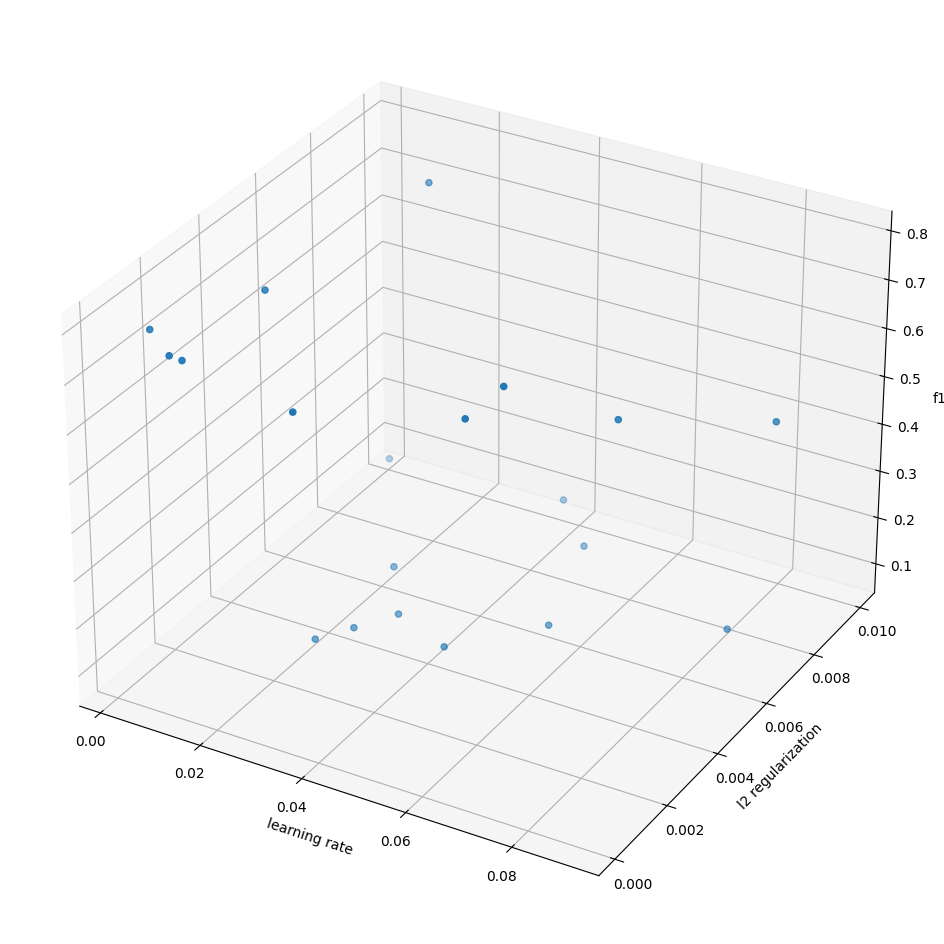

In [22]:
lrs = []
l2rs = []
f1s = []

for trial in study.trials:
    lr = trial.params.get('lr')
    l2r = trial.params.get('weight_decay')
    f1 = trial.value

    lrs.append(lr)
    l2rs.append(l2r)
    f1s.append(f1)
    

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

ax.scatter(lrs, l2rs, f1s)
ax.set_xlabel('learning rate')
ax.set_ylabel('l2 regularization')
ax.set_zlabel('f1')